In [2]:
%load_ext autoreload
%autoreload 2
from importlib import reload

from collections import defaultdict

import numpy

import random
from matplotlib import pyplot as plt
from random import shuffle, choice, randint

import math
import keras
import tensorflow

from NN_utils import BigTable, WeightClip

import pickle
import zlib

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/(comps))
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

print("started")


from sklearn.svm import SVR

started


In [3]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits):
    students = numpy.zeros((n_students, n_factors))
    for six in range(n_students):
#         true_comps = numpy.random.normal(a0, a1, size=n_factors)#+0.2#+2#+1.2
#         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
        true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
        for cix,c in zip(range(n_factors), true_comps):
            students[six,cix] = c

    questions = numpy.zeros((n_questions, n_factors))
    for qix in range(n_questions):
#         n_comps = randint(min_active_traits, max_active_traits)
        n_comps = n_factors
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)
        true_comps = numpy.random.uniform(a0[0],a0[1], size=n_comps)

        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c#+boost
    
    print("genqs",students.shape, questions.shape)
    return students, questions

def gen_bayes_run(n_traits, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits)
    print(students.shape, questions.shape)
    obs = numpy.zeros((len(students), len(questions)))
    probs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    for vi in range(len(students)):
        for mi in range(len(questions)):
            prs = (1-questions[mi]) + (questions[mi]*students[vi])
            pr = numpy.prod(prs)
            obs[vi,mi] = (random.random() < pr)
            probs[vi,mi] = pr
    return obs, probs, students, questions

# n_students, n_questions, n_factors, min_active, max_active = 100,100,10,10,10

In [4]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits, test_w):
    students = numpy.zeros((n_students, n_factors))
#     for six in range(n_students):
#         true_comps = numpy.random.normal(0, a1, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
#         for cix,c in zip(range(n_factors), true_comps):
#             students[six,cix] = c

    students = numpy.random.normal(0, a1, size=(n_students,n_factors))
            
    av_c = (min_active_traits + max_active_traits)/2
    d50 = pr_to_spread(.5, av_c, as_A_and_D=False)
    
    questions = numpy.zeros((n_questions, n_factors)) - 10
    
    minb=-(test_w/2) -a0 - d50
    maxb=(test_w/2) -a0 - d50
    questions = questions
    minb, maxb = sorted([minb, maxb])
    minb = float(minb)
    maxb = float(maxb)
    
    for qix in range(n_questions):
        n_comps = randint(min_active_traits, max_active_traits)
#         print("n_comps", n_comps)
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)  
#         print("range=", minb,maxb)
        true_comps = numpy.random.uniform(minb, maxb, size=n_comps)
        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c
            
    return students, questions


def calc_probs_from_embs(students,questions):
    students2 = numpy.repeat(students, len(questions), axis=0)
    questions2 = numpy.tile(questions, (len(students),1))
    zmask = numpy.isclose(questions2,-10).astype(int)
    diffs = students2-questions2
    prs = 1.0/(1.0+ numpy.exp(-diffs))
    prs = numpy.maximum(zmask,prs)
    probs2 = numpy.prod(prs, axis=1).reshape(len(students), len(questions))
    return probs2

def gen_rasch_run(n_traits, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits, test_w=test_w)
    obs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    
#     students2 = numpy.repeat(students, n_questions, axis=0)
#     questions2 = numpy.tile(questions, (n_students,1))
    
# #     print("st and qn shapes:")
# #     print(students.shape)
# #     print(questions.shape)
    
#     zmask = numpy.isclose(questions2,-10).astype(int)
# #     print("zmask shape:", zmask.shape)
#     diffs = students2-questions2
# #     print("diffs shape:", diffs.shape)
#     prs = 1.0/(1.0+ numpy.exp(-diffs))
#     prs = numpy.maximum(zmask,prs)
#     probs2 = numpy.prod(prs, axis=1).reshape(n_students, n_questions)
        
    probs2 = calc_probs_from_embs(students, questions)
#     for vi in range(len(students)):
#         for mi in range(len(questions)):
#             zmask = numpy.isclose(questions[mi],-10).astype(int)
#             diffs = students[vi]-questions[mi]
#             prs = logistic(diffs,1,0)
#             prs = numpy.maximum(zmask,prs)

#             pr = numpy.prod(prs)
#             obs[vi,mi] = (random.random() < pr)
#             probs[vi,mi] = pr
            
    return obs, probs2, students, questions



In [5]:
# from scipy.stats import beta
# # n_questions = 100
# # n_students = 100
# # n_factors = 2

# def gen_run(n_movies, n_viewers, n_factors, min_active, max_active):
#     from numpy.random import randint, uniform

#     mina,maxa =(0,1)
#     minb,maxb =(0,1)
#     movies = randint(minb, maxb+1, size=(n_movies, n_factors))
#     viewers = randint(mina, maxa+1, size=(n_viewers, n_factors))
# #     movies =  beta.rvs(2, 2, size=(n_movies, n_factors))
# #     viewers = beta.rvs(2, 2, size=(n_movies, n_factors))

#     plt.hist(movies.flatten(), alpha=0.5)
#     plt.hist(viewers.flatten(), alpha=0.5)
#     plt.show()
    
#     print(movies)
#     print(viewers)

#     sig = lambda z : 1/(1+numpy.exp(-z))

#     obs = numpy.zeros((len(viewers), len(movies)))
#     #obs = numpy.matmul(viewers, movies.T)/n_factors
#     vz = []
#     mz = []
#     scz =[]
#     for vi in range(len(viewers)):
#         for mi in range(len(movies)):
# #             obs[vi,mi] = numpy.prod(sig(viewers[vi] - movies[mi]))
#             obs[vi,mi] = numpy.dot(viewers[vi], movies[mi])
# #             prxd = numpy.multiply(viewers[vi], movies[mi])
# #             obs[vi,mi] = numpy.sum(prxd)
# #             obs[vi,mi] = numpy.random.randint(0,2)
#             print(viewers[vi], movies[mi],"=",obs[vi,mi])
#     plt.hist(obs.flatten())
#     plt.show()
    
#     return obs, None, viewers, movies

In [6]:
# n_students, n_questions, n_factors, min_active, max_active = 100,150,100,1,5

# numpy.set_printoptions(precision=3)
# test_w = 5
# #rasch a0 = 3
# # a0 = 0.26 #bayes10
# a0 = (0.2,1)
# a1 = None
# # obs, probs, students, questions  = gen_bayes_run(n_factors, a0, a1, min_active, max_active, test_w=test_w, n_students=n_students, n_questions=n_questions)
# obs, probs, students, questions  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w=test_w, n_students=n_students, n_questions=n_questions)

# plt.hist(students.flatten(), alpha=0.5)
# plt.hist(questions.flatten(), alpha=0.5)
# plt.show()

# plt.hist(probs.flatten())
# plt.show()

# plt.hist(obs.flatten())
# plt.show()

In [7]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Embedding, Flatten
from keras import backend as K, Model
def generate_qs_model(qn_table, psi_table, optimiser, _mode="MXFN", loss="MSE"):
    
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")

#     psi_row = Flatten(Embedding(psi_n, 100, input_length=1)(psi_sel))
#     qn_row = Flatten(Embedding(qn_n, 100, input_length=1)(qn_sel))
    
#     print(qn_table, psi_table, psi_sel, qn_sel)
#     print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)

    print("Mode is", _mode)
    if _mode=="DEEP":
        difs = subtract([psi_row, qn_row])
        h = Dense(50, activation="relu")(difs)
        h = Dense(50, activation="relu")(h)
        h = Dense(50, activation="relu")(h)
        h = Dense(20, activation="relu")(h)
        score = Dense(1, activation="sigmoid")(h)        
    elif _mode=="COND":
        Prs = Lambda(lambda qs: (1 - qs[0])+(qs[0]*qs[1]), name="Prs")([qn_row, psi_row])
        score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
#     elif _mode=="BINQ":
#         Prs = Lambda(lambda qs: (1 - qs[0])+(qs[0]*qs[1]), name="Prs")([qn_row, psi_row])
#         score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    elif _mode=="MLTM":
        klip = Lambda(lambda qk: K.clip(qk,-10, -9)+10)
        q_masque = klip(qn_row)
        difs = subtract([psi_row, qn_row])
        Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
        Prs = Lambda(lambda ps_q:  ps_q[0]*ps_q[1] + (1-ps_q[1]) ) ([Prs, q_masque])
        score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    else:
        if _mode!="MXFN":
            print("Invalid mode:", _mode, "- valid modes are COND, MLTM, MXFN (using default: MXFN)")
        _mode=="MXFN"
        scores = Lambda(lambda qp: qp[0] * qp[1])([qn_row, psi_row])
        score = Lambda(lambda s: K.sum(s, keepdims=True, axis=1), name="sum")(scores)
#         score = Lambda(lambda qp: K.batch_dot(qp[0], qp[1], axes=1), name="dot_prod")([qn_row, psi_row])
    #     score = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)))(score)
    
    model = Model(inputs=[qn_sel, psi_sel], outputs=score)

#     if _mode=="BINQ":
#         from_half = Lambda(lambda x: 1+K.sum((0.25-(x-0.5)**2)) )
#         s_loss = from_half(psi_table.kernel)
#         q_loss = from_half(qn_table.kernel)
#         def custom_loss(s_loss,q_loss):
#             def orig_loss(yt,yh):
#                 return K.binary_crossentropy(yt,yh) * s_loss * q_loss
# #             return K.mean(K.square(yt-yh)) + 5000*aux_av + 1000*aux_std + aux_loss/10000
#             return orig_loss
#         model.compile(optimizer=optimiser, loss=custom_loss(s_loss, q_loss), metrics=["accuracy"])
#         return model
    
    print("loss mode is", loss)
    if loss=="MSE":
        model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])
    else:
        if loss!="XENT":
            print("loss mode must be MSE or XENT, not", loss," - setting to XENT.")
            loss="XENT"            
        model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])     
    print(model.summary())

    return model

In [8]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Dense
from keras import backend as K, Model
from keras.optimizers import Adam
def generate_offset_generator(w=5,d=4):
    #width, dispersal, target_EV
    h=None
    inp = Input(shape=(3,))
    for _ in range(d):
        if h==None:
            h = Dense(w, activation="relu")(inp)
        else:
            h = Dense(w, activation="relu")(h)
    last_layer=inp if (h is None) else h
    offset = Dense(1, activation="linear")(last_layer)
    model = Model(inputs=[inp], outputs=[offset])
    model.compile(optimizer=Adam(), loss="mse")
    print(model.summary())
    return model

In [12]:
# a1 = 5/3
# a0 = 1.75
# tw = 3.5
from sklearn.metrics import mean_squared_error

from keras.callbacks import EarlyStopping
def create_offset_generator(n_factors, min_active, max_active, sampsize=14, n_iter=20000, rasch=True):
    n_questions = int(sampsize / 0.9)
    n_students = int(sampsize / 0.9)
    inps = []
    outs = []

    i=0
#     for a in range(n_iter):
    print("generating generator training mini-datasets...")
    n_dropped = 0
    while i < n_iter:

#         tw = random.uniform(0, 5)
#         a0 = random.uniform(-4, 5)
#         a1 = random.uniform(.5, 4)

        tw = random.uniform(0, 5)
        a0 = random.uniform(-5, 5)
        a1 = random.uniform(0, 4)

#         tw = random.uniform(0, 10)
#         a0 = random.uniform(-10, 10)
#         a1 = random.uniform(0, 10)


#         print(tw,a1,"...",a0)
        
        if rasch:
            _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
        else:
            _, _, students_temp, qz_temp  = gen_bayes_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)

        students2 = students_temp
        questions = qz_temp


        obs = (random.random() < probs).astype(int)
        exp_ob = numpy.mean(probs.flatten())
        if exp_ob <= 0.1 or exp_ob >= 0.9:
            n_dropped +=1
            continue
        i+=1
            
#         hard =numpy.round(probs)
#         plt.hist(hard.flatten())
#         plt.show()

#         agt = 0 #numpy.zeros_like(probs)
#         n_agt_runs = 20
#         for _ in range(n_agt_runs):
#             this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
# #             plt.hist(this_obs.flatten())
# #             plt.show()
#             this_agt = numpy.mean(((hard==this_obs).astype(float)).flatten())
# #             this_agt= numpy.std(probs.flatten() -0.5 )
# #             print("Agt:", this_agt)
#             agt += this_agt 
#         agt /= n_agt_runs
        
#         plt.hist(probs.flatten())
#         plt.show()
#         print("tw, a1, a0", tw, a1, a0)
#         print("Mean agt:", agt)
#         print("Exp pr:", exp_ob)
        
        
        print(i, exp_ob)
        inps.append([tw,a1, exp_ob])
        outs.append(a0)
#         for p in probs.flatten():
#             inps.append([tw,a1, p])
#             outs.append(a0)
        
    print("done!")

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    
    split = len(inps)//10
    vinps = numpy.array(inps[split:])
    vouts = numpy.array(outs[split:])
    inps = numpy.array(inps[:split])
    outs = numpy.array(outs[:split])
    print(inps.shape, outs.shape)

    best_mse = math.inf
    best = None
    best_dims = None
#     seen = set()
                        
    for nnw in [16]: # [2,4,8,16,32]:
        for nnd in [2]: #[0,1,2,3,5]:
#             if (nnw,nnd) in seen:
#                 continue
#             seen.add((nnw,nnd))
            gen_m = generate_offset_generator(nnw, nnd)
            h = gen_m.fit(inps,outs, epochs=10000, shuffle=True, batch_size=len(inps), callbacks=[es], validation_split=0.1, verbose=1)
            
#             gen_m = SVR()
#             gen_m.fit(inps, outs)
            
            mse = mean_squared_error(vouts,gen_m.predict(vinps))
            if mse < best_mse:
                print("new best:",nnw,nnd,":",mse)
                best_mse = mse
                best_dims = (nnw,nnd)
                best = gen_m
    
    predz = best.predict(inps)
#     for i,p,o in zip(inps,predz, outs):
#         print(i, p, o)
    print("Best generator for", (n_factors, min_active, max_active), "is", best_dims)
    print("avg", numpy.mean(outs), "vs", numpy.mean(predz))
    print("number of extreme cases = ", n_dropped, "as prop of ",n_iter," iters", n_dropped/n_iter)
    print(mean_squared_error(vouts, best.predict(vinps)))
    
    h=None
    return best, h, best_dims, best_mse

In [8]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    print(split, real_wgts.shape, pred_wgts.shape, max_iter)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    curr_real_ix = None
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
                    if err < curr_err:
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = numpy.array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        
        dis = 0
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_dis = dis
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_dis


In [9]:
import copy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_items(pred_list, real_items, s_offset):
    if real_items.shape[1]<2:
        print("real_items is only 1 component wide .. needs to be >1 to plot on a PCA graph")
        return None
    elif real_items.shape[1]==2:
        print("2 comps, so no dim reduc")
        tx=None
    else:
        tx = PCA(n_components=2)
#         tx = TSNE(n_components=2)
    fyrst = True
    Cs = []
    C_labs = []
    pred_list = numpy.array(pred_list)
    print("pred list shape", pred_list.shape)
    print("real items shape", real_items.shape)


    fitted_pred_list = []
#     offset = numpy.median(pred_list[(pred_list>0.1)], axis=0) - numpy.median(real_items[(real_items>0.1)], axis=0)
#     real_mean = numpy.min(real_items[real_items > 0.1])
#     offset = numpy.min(pred_list[pred_list > 0.1]) - real_mean
#     print("real mean", real_mean)
#     print("offset", offset)
    
    m = len(real_items)
    cols = list(range(m))
    shuffle(cols)
    
    xmeans = numpy.zeros(m)
    ymeans = numpy.zeros(m)
    pairs = defaultdict(list)
    iter = 0
    
    cp_real = copy.copy(real_items)
    cp_real[cp_real < 1] = numpy.nan
    r_offset=numpy.nanmedian(cp_real, axis=0)
    
    itemz_2 = real_items
    n = len(real_items)
    
    for opreds in pred_list:
        preds = copy.copy(opreds) #- s_offset[iter] + r_offset
        split = 0
        
        items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_items, preds, max_iter=10)

        itemz_pred = items_chosen
        print(itemz_pred)
#         itemz_pred = numpy.maximum(itemz_pred,0)
        fitted_pred_list.append(itemz_pred)
        
#         itemz = real_items #- offset
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         itemz = numpy.maximum(itemz,0)
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         if itemz_2 is None:
#             itemz_2 = numpy.concatenate([real_itemz, itemz_pred], axis=0)
#         else:
        itemz_2 = numpy.concatenate([itemz_2, itemz_pred], axis=0)

    if tx:
        itemz_2 = tx.fit_transform(itemz_2)
#         itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
#         if fyrst:
#         itemz_2 = tx.fit_transform(itemz_2)
#             fyrst = False
#         else:
#             itemz_2 = tx.transform(itemz_2)

    from sklearn.cluster import KMeans
    iter=0
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    
    for opreds, itemz_pred in zip(pred_list, fitted_pred_list):
        n = len(itemz_pred)
        km = KMeans()
        km.fit(itemz_pred)
        cluster_labels = km.predict(itemz_pred)
        print(cluster_labels)
        
        C = []
        for l in set(cluster_labels):
            cluster = list(numpy.where(cluster_labels==l)[0])
            print("X", cluster)
            C.append(cluster)
        Cs.append(C)
        C_labs.append(cluster_labels)
                
#         NUM_COLORS = 100
#         cm = plt.get_cmap('gist_rainbow')
#         fig.gca().set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        print(type(itemz_2))
        minix=n*(iter+1)
        maxix=n*(iter+1)+n
        
        #i=0 -> 100,199
        #i=2 -> 200,299
        
        print("no pts=",n," indices=", minix, maxix)
        print("shape of itemz_2", itemz_2.shape)
        fig.gca().scatter(itemz_2[minix:maxix,0], itemz_2[minix:maxix,1], alpha=0.7, c=numpy.array(cols), cmap=plt.get_cmap('nipy_spectral'))
        j=0
        for j in range(n):
            x,xh,y,yh = itemz_2[j+(n*iter),0], itemz_2[j+(n*iter+n) ,0], itemz_2[j+(n*iter),1], itemz_2[j+(n*iter+n),1]
#             fig.gca().plot([x,xh],[y,yh],  color="#aaaaaa80")
            xmeans[j] += xh
            ymeans[j] += yh
            pairs[iter].append((xh, yh))
        iter+=1
        
    for j in range(n):
        fig.gca().annotate(j, (itemz_2[j,0], itemz_2[j,1]))
        
    fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], c="b", zorder=10, alpha=0.5)
#     fig.gca().axhline(y=1e-6, linestyle="--")
#     fig.gca().axvline(x=1e-6, linestyle="--")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    xmeans = xmeans / len(pred_list)
    ymeans = ymeans / len(pred_list)
    

    if len(pred_list)>=1:
        for it in range(len(pred_list)):
            xhyh_pairs = pairs[it]
            for j,hat_pair in enumerate(xhyh_pairs):
                xh,yh = hat_pair
                x,y = itemz_2[j,0], itemz_2[j,1]
                mux = xmeans[j]
                muy = ymeans[j]
#                 fig.gca().scatter(xh, yh, alpha=0.7, c=plt.get_cmap('nipy_spectral')(cols[j]))
#                 fig.gca().scatter(mux,muy, c="#888888ff", marker="*", zorder=10)
#                 fig.gca().plot([mux,xh],[muy,yh],color="#aaaaaa80", linestyle="--")
#                 fig.gca().plot([mux,x],[muy,y],color="#888888dd", linestyle="-")
                fig.gca().plot([x,xh],[y,yh],color="#aaaaaa80", linestyle="--")
        
    plt.show()
    print("len Cs", len(Cs))
    from sklearn.metrics.cluster import adjusted_rand_score
    rands = []
    for ix in range(len(Cs)):
#         print(ix)
        for jx in range(len(Cs)):
#             print(jx)
            if ix!=jx:
#             print(Cs[ix], Cs[jx])
#                 print("VI:", ix,jx, varinfo(Cs[ix],Cs[jx]))
                a_rand = adjusted_rand_score(C_labs[ix], C_labs[jx])
                print("Rand:", a_rand)
                rands.append(a_rand)
    print("Mean rand score =", numpy.mean(rands), numpy.std(rands))

# qws = qn_table.get_weights()[0]
# qws2 = qn_table2.get_weights()[0]

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score
def generate_and_train(n_students, n_questions, qz,sz,pfz, vqz,vsz,vpfz, w, n_factors, min_active, max_active, nn_mode=None, loss_mode=None):
    btm = 0
    top = math.sqrt(.1/w)
#     init= (btm,top)
#     init = math.sqrt(.5/w)
    init_s = (0,1)
    init_q = (0,1)
    
#     1-p + pq = s
#     q=0.3 : 1-p + p/3 = s
#           : 3-3p + p = s
#           : p = (3-s)/2
        
    if nn_mode=="COND":
        percompp = .5**(1/w)
        print("percompp", percompp)

        s_table =  BigTable((n_students, w), 0,1, init_hilo= percompp )#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), 0,1, init_hilo= percompp )#, regulariser=regularizers.l1(10e-6))
    elif nn_mode=="MXFN":
        init = math.sqrt(.5/w)
        print("MXFN init'n")
        print(init)
        print(init*init*w)
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= init) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= init) #, regulariser=regularizers.l1(10e-6))
    elif nn_mode=="MLTM":
        sp = pr_to_spread(.5, w, as_A_and_D=False)
        print("sp is ",sp)
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= -sp) #, regulariser=regularizers.l1(10e-6))        
    else:
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l1(10e-6))        
                
    from keras.layers import Embedding
    from keras.constraints import NonNeg, MinMaxNorm
    from keras.initializers import RandomNormal, RandomUniform
    
#     wc=WeightClip(0,1)
    
#     q_gates = None #Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomUniform(minval=0, maxval=1, seed=None), embeddings_constraint=wc)
#     qn_table = Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
#     s_table = Embedding(n_students,w, input_length=1, embeddings_constraint=WeightClip(0,math.inf), embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
    
    from keras.optimizers import Adam
    from keras.callbacks import EarlyStopping
    
#     vqz=[]
    if len(vqz)>0:
        lozz="val_loss"
        val_dat= [[vqz,vsz], vpfz]
    else:
        lozz="loss"
        val_dat=None
    
    fiftiez = numpy.zeros_like(pfz) + .50
    for _ in range(1):
#         es = EarlyStopping(monitor="loss", restore_best_weights=True, patience=10)
#         m = generate_qs_model(qn_table, s_table, Adam(lr=0.001))
#         h = m.fit(x=[qz,sz], y=numpy.array(fiftiez).reshape(-1,1), batch_size=len(pfz), shuffle=True, epochs=10000, verbose=1, callbacks=[es])
#         wz = m.get_weights()
        m = generate_qs_model(qn_table, s_table, Adam(), _mode=nn_mode, loss=loss_mode)
#         m.set_weights(wz)
        tr_predz = (m.predict([qz,sz]) > 0.5)
        v_predz  = (m.predict([vqz,vsz]) > 0.5)
#         for vs,vq,tp,pp in zip(vsz,vqz,predz, vpfz):
#             print(vs,vq,"-",tp,pp)
        print("PRE-TR AVG  = ", numpy.mean(tr_predz))
        print("PRE-TR VAVG = ", numpy.mean(v_predz))

        es = EarlyStopping(monitor=lozz, restore_best_weights=True, patience=10)
        
        _bs = len(pfz)
#         _bs = 32
        h = m.fit(x=[qz,sz], y=numpy.array(pfz).reshape(-1,1), batch_size=_bs, shuffle=True, epochs=10000, verbose=1, callbacks=[es], validation_data=val_dat)
        tr_predz = m.predict([qz,sz])  
        v_predz  = m.predict([vqz,vsz])

        print("TR AVG = ", numpy.mean(tr_predz))
        print("TR R2  = ", r2_score(pfz, tr_predz))
        print("TR MAE = ", mean_absolute_error(pfz, tr_predz))
        print("TR ACC = ", accuracy_score(pfz, (tr_predz>0.5)))
        print("TR AGT = ", accuracy_score([random.random() < p for p in pfz], [random.random() < p for p in tr_predz]))
        
        if val_dat:
            print("VA AVG = ", numpy.mean(v_predz))
            print("VA R2  = ", r2_score(vpfz, v_predz))
            print("VA MAE = ", mean_absolute_error(vpfz, v_predz))
            print("VA ACC = ", accuracy_score(vpfz, (v_predz>0.5)))
            print("VA AGT = ", accuracy_score([random.random() < p for p in vpfz], [random.random() < p for p in v_predz]))

    from sklearn.metrics import classification_report
    print(classification_report(pfz, (tr_predz>0.5)))
    print(classification_report(vpfz, (v_predz>0.5)))
            
#     h = m.fit(x=[qz,sz], y=pfz.flatten(), batch_size=32, shuffle=True, epochs=1000, verbose=1, callbacks=[es], validation_data=[[vqz,vsz], vpfz])
    return s_table, qn_table, m, h


In [11]:
def stitch_n_split(_pairs, _probs):
    _pfz = numpy.array([int((random.random() < _probs[vi,mi])) for (vi,mi) in _pairs])
#     _pfz = numpy.array([probs[vi,mi] for (vi,mi) in pairs])
    _sz = [p[0] for p in _pairs]
    _qz = [p[1] for p in _pairs]
    return _pfz, _sz, _qz

In [11]:
def calc_skills_coverage():
    xs=[]
    ys=[]
    ycnts=[]
    n_factors, min_active, max_active = 100,1,5
    n_students = 1
    tw=1
    a0=1
    a1=1
    max_n_qns = 150
    n_questions_list = numpy.linspace(1,max_n_qns,num=10).astype("int")

    _, _, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=max_n_qns)
    for n_questions in n_questions_list:
        cnt = numpy.array([False]*n_factors).astype("int")
#         plt.hist(qz_temp.flatten(), alpha=0.5)
#         plt.show()
        for q in qz_temp[0:n_questions]:
            active = (q > -10).astype("int")
#             print("a",active)
            cnt = cnt + active
            seen = numpy.clip(cnt, 0,1)
        print("c",cnt)
        print(n_questions, numpy.mean(seen), numpy.mean(cnt))
        xs.append(n_questions)
        ys.append(numpy.mean(seen))
        ycnts.append(numpy.mean(cnt))
    plt.plot(xs,ys)
    plt.plot(xs,ycnts)
    plt.show()
    
calc_skills_coverage()

NameError: name 'n_factors' is not defined

In [12]:
gen_m_cache = pickle.load(open("generators.p", "rb"))

In [10]:
gen_m_cache = {}

In [14]:
tup = (100,1,5)
n_factors, min_active, max_active = tup

sss = [10,20,30,50,70]
nits = [1000,10000,50000]

for ss in sss:
    for nit in nits:
        key = ((tup,(nit,ss)))
#         if key in gen_m_cache:
#             del gen_m_cache[key]
        print("creating genny")
        gen_m, history, best_dims, best_mse = create_offset_generator(n_factors, min_active, max_active, sampsize=ss, n_iter=nit)
        gen_m_cache[key] = (gen_m, history, best_dims, best_mse)

        # summarize history for loss
#         plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
#         plt.title('Model loss for {}x{}'.format(ss,nit))
#         plt.ylabel('loss')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='upper right')
#         plt.show()

39543 0.5651298115238537
39544 0.1205996483838861
39545 0.5641287955381453
39546 0.42587037971944214
39547 0.7233006184215993
39548 0.5199397589566955
39549 0.3987444625414482
39550 0.5705254787081655
39551 0.19219942726570538
39552 0.5924803996734885
39553 0.2089699992681207
39554 0.7154728091997845
39555 0.2741943640516854
39556 0.11557535846891587
39557 0.4404708663739735
39558 0.25207422292520043
39559 0.5792324670699314
39560 0.820855496290859
39561 0.4626919811169828
39562 0.753227110369268
39563 0.7421169955048647
39564 0.7693211576787502
39565 0.7018890409031027
39566 0.8830676460313265
39567 0.34888567890431144
39568 0.7568662900222632
39569 0.1361595832633481
39570 0.2801336329862868
39571 0.26598309287425026
39572 0.21251234164331326
39573 0.5400374356441301
39574 0.828763410875784
39575 0.6188232756168448
39576 0.40741121039131467
39577 0.1515661196157054
39578 0.12148961884562186
39579 0.7781694431172381
39580 0.7914665161260883
39581 0.1675012425562684
39582 0.45109444739

39874 0.8381152952473298
39875 0.22081214833865545
39876 0.1515921434143488
39877 0.6234002044135759
39878 0.6935281020465148
39879 0.27392820537800144
39880 0.18292457853615596
39881 0.5924048017886565
39882 0.4993285980591197
39883 0.2738455325735075
39884 0.8093754420655865
39885 0.6153207575807027
39886 0.5887322620716319
39887 0.29874922480082766
39888 0.8655198399413776
39889 0.6120463451772965
39890 0.3649838634353594
39891 0.21828358608313964
39892 0.8795842497149895
39893 0.1314535722339902
39894 0.311093414303822
39895 0.10544682964857248
39896 0.8684767136932063
39897 0.2769147446678763
39898 0.7231520731783401
39899 0.12971423014695746
39900 0.7710023987195257
39901 0.12555310190185862
39902 0.2581873597743858
39903 0.7258116217580171
39904 0.2739783661371898
39905 0.6337771308763304
39906 0.5649867664292864
39907 0.4973228184584719
39908 0.5476309331035966
39909 0.14989223338231536
39910 0.27303249634076265
39911 0.7248233894941551
39912 0.2167506897664809
39913 0.26618094

40200 0.7341029400564327
40201 0.8200926643546954
40202 0.5159927350016457
40203 0.18573358659530576
40204 0.22437332661729478
40205 0.3144144232152692
40206 0.6431892380497775
40207 0.775652225242634
40208 0.2654792495927635
40209 0.23932280085028199
40210 0.530106231997939
40211 0.3363753257075717
40212 0.6466408872708882
40213 0.1452018949731106
40214 0.8456962919551839
40215 0.4320496045678627
40216 0.2534423153505713
40217 0.5779717442239318
40218 0.6842468317933365
40219 0.7603768613256684
40220 0.1856482600851494
40221 0.6029665894504194
40222 0.39832314649825
40223 0.8798362390508232
40224 0.8589263876140266
40225 0.7993828884551132
40226 0.3652273651718249
40227 0.11122344972618958
40228 0.7134653268199397
40229 0.48501052526886135
40230 0.24838840261801987
40231 0.6026591544784322
40232 0.5195870809078944
40233 0.8696634926645603
40234 0.8882536537380027
40235 0.21190123102102978
40236 0.14212030693228297
40237 0.6358855323605596
40238 0.46251605710007215
40239 0.144825442524

40531 0.12493197709073782
40532 0.30488387411858775
40533 0.3928128141314235
40534 0.8367019212972422
40535 0.3008591810750242
40536 0.8378790736737871
40537 0.23050367675872085
40538 0.7731633188886681
40539 0.1443306710099969
40540 0.6395839570060325
40541 0.5950806299178373
40542 0.6240558583852401
40543 0.11832235974314165
40544 0.8600879066193028
40545 0.7992900097790785
40546 0.3124693094388034
40547 0.7639248325286986
40548 0.2644884162165812
40549 0.32203858516378053
40550 0.6188430255645511
40551 0.21652244210487515
40552 0.1742080215127474
40553 0.43635088638862957
40554 0.4237696353199423
40555 0.11865032897254087
40556 0.5429853526186594
40557 0.6629383022055263
40558 0.7662979175389261
40559 0.46854690204395844
40560 0.3969403507933909
40561 0.5930377191309075
40562 0.633661686097381
40563 0.16530045200819735
40564 0.8542620141147705
40565 0.5161337857357379
40566 0.3294283676552834
40567 0.319467147218266
40568 0.2399397840036531
40569 0.4327638188621621
40570 0.899069467

40857 0.6791160978601529
40858 0.40033369311976996
40859 0.10127709646332926
40860 0.5151333766938404
40861 0.5743316560133187
40862 0.3941195618168949
40863 0.5925488795746612
40864 0.49597530421473857
40865 0.8733982892523265
40866 0.42242976648842245
40867 0.7138188742853249
40868 0.8012753790443545
40869 0.14012021008950162
40870 0.19648807675317362
40871 0.5899382576722874
40872 0.27798632601734447
40873 0.5458700144741654
40874 0.7759975432411366
40875 0.19724518639675825
40876 0.21837937130791413
40877 0.5844280493226538
40878 0.13330960139706952
40879 0.18731094658308078
40880 0.10980665608692362
40881 0.10676167465608763
40882 0.2978793413951099
40883 0.39635971746541543
40884 0.26319282808317923
40885 0.6414271796783537
40886 0.2856623588386531
40887 0.3285135686122187
40888 0.34675953508776025
40889 0.7363063692044276
40890 0.30797955839216923
40891 0.4924194706184984
40892 0.20389074992840886
40893 0.8442468906126995
40894 0.1539126554550627
40895 0.20100004170588626
40896 

41183 0.6129627627716694
41184 0.8694284553741631
41185 0.2740400827755458
41186 0.6519636579314495
41187 0.7969366464856626
41188 0.2887293958970526
41189 0.1245237175932522
41190 0.19513004691234268
41191 0.677683355297727
41192 0.2626742486150617
41193 0.12203209652892473
41194 0.1437722037280896
41195 0.8571024263483155
41196 0.15368180965185324
41197 0.31028172283878785
41198 0.7139981753956472
41199 0.6619983360809982
41200 0.20884524254883052
41201 0.10335225516861207
41202 0.7262412558083713
41203 0.8379692224792856
41204 0.5657962270779892
41205 0.8436796995592756
41206 0.4654282602339655
41207 0.10173295417885558
41208 0.5373806329998886
41209 0.8065831184973168
41210 0.23462294573391596
41211 0.7872067411014065
41212 0.2789802248940008
41213 0.3434381717518739
41214 0.58347703479502
41215 0.6171147809345754
41216 0.38040122839106927
41217 0.7481456710297761
41218 0.13819616792787628
41219 0.4686011150075726
41220 0.3857767396297057
41221 0.8520286894080954
41222 0.8394435804

41511 0.862045194887487
41512 0.4753556442959618
41513 0.11705468773882384
41514 0.10908885064971786
41515 0.14456027548241462
41516 0.6835840154580713
41517 0.44414539830050026
41518 0.7703585122975537
41519 0.6229333440515195
41520 0.12828351616236935
41521 0.8441224151804902
41522 0.3997756943719751
41523 0.3708511690042262
41524 0.17498081076626842
41525 0.886876502923735
41526 0.410145284536497
41527 0.8910719981051305
41528 0.6239476888349673
41529 0.8423802007643949
41530 0.2141991005538566
41531 0.44283057977145585
41532 0.751388818529185
41533 0.6192401645957138
41534 0.16445659045461883
41535 0.7491895750813127
41536 0.11333783059323851
41537 0.5708921098821108
41538 0.18727249240280233
41539 0.8818290383637545
41540 0.15111571864953133
41541 0.12123008819660237
41542 0.24063312850463003
41543 0.8769997984986287
41544 0.8847404893144615
41545 0.8028424439697278
41546 0.637406386644876
41547 0.23963449815547536
41548 0.6691336338334647
41549 0.183485094175536
41550 0.827455467

41841 0.3617175095440567
41842 0.21989597220790072
41843 0.5611764416073296
41844 0.6815746469256151
41845 0.2586984003302981
41846 0.3908776296706326
41847 0.1539443359295065
41848 0.7510771074066415
41849 0.34961215410961843
41850 0.2677229354792643
41851 0.2303411882072152
41852 0.8043660203726258
41853 0.10123911667473619
41854 0.19323868302801855
41855 0.21409797976740078
41856 0.6868943270711435
41857 0.252265072804418
41858 0.3871162188735405
41859 0.1622020103487495
41860 0.2608723055260731
41861 0.13860841743225044
41862 0.7793455861008184
41863 0.20502144258735447
41864 0.7353910929413094
41865 0.4501126483727878
41866 0.6820194871165172
41867 0.5296919480947024
41868 0.3239357017605121
41869 0.4571615559677867
41870 0.5284574293561779
41871 0.7011240037169361
41872 0.7580020787386585
41873 0.2773551486805223
41874 0.8582986970535853
41875 0.40428328141973174
41876 0.8389468678347023
41877 0.6224840148369051
41878 0.8578044454059567
41879 0.24231486819097497
41880 0.767148467

42167 0.8570849985722158
42168 0.20294149986816903
42169 0.38846181205497043
42170 0.16644825941753805
42171 0.8640107651987268
42172 0.33604354790441077
42173 0.7485037077251866
42174 0.33581796673904163
42175 0.24640855778968862
42176 0.16927021654849791
42177 0.4580704963038578
42178 0.2427896419158114
42179 0.7561297312443238
42180 0.6681743555867664
42181 0.3196958303537483
42182 0.6047165672331875
42183 0.2327697811976612
42184 0.46317081212104794
42185 0.8988335562895342
42186 0.8907456962568718
42187 0.8988262388914275
42188 0.3284196660486272
42189 0.4096900947967494
42190 0.8951751421037816
42191 0.327458115195769
42192 0.36427198977360503
42193 0.5204428993945078
42194 0.32168596313283543
42195 0.31453900032079507
42196 0.10834924425616284
42197 0.6109601123970626
42198 0.12714353580467305
42199 0.1554762042983341
42200 0.24068846033199714
42201 0.3398649124594929
42202 0.3054938656292124
42203 0.2230582644273576
42204 0.8213591776309058
42205 0.19907629493934834
42206 0.198

42495 0.6035646381297975
42496 0.16708589526092296
42497 0.12520255729711532
42498 0.33987318938023114
42499 0.18710618921093247
42500 0.42157843231511444
42501 0.21420461518096715
42502 0.11742007465791869
42503 0.20420919200148188
42504 0.7413242059970709
42505 0.7395052429450724
42506 0.8495183418825415
42507 0.13349975064649336
42508 0.8180315704134596
42509 0.6813855800592743
42510 0.7540278939346428
42511 0.16038925326678288
42512 0.29997182460115834
42513 0.7919525893603832
42514 0.29309056815602935
42515 0.15513715595429656
42516 0.7083801823294463
42517 0.6159440059938249
42518 0.8232705112368145
42519 0.3461978676791637
42520 0.59510658903168
42521 0.17812325916557997
42522 0.5698125958240006
42523 0.8915472545130521
42524 0.704508908163005
42525 0.6856903817014808
42526 0.11392418094628766
42527 0.5601705524785799
42528 0.12649439951489
42529 0.3726252969464762
42530 0.15610973057955782
42531 0.5754347446099553
42532 0.2209047115352823
42533 0.7564971271614789
42534 0.742239

42820 0.4053812205743314
42821 0.31214446937213414
42822 0.671656391435938
42823 0.4471854197162768
42824 0.21655481560595588
42825 0.2005315719438563
42826 0.6257774750999573
42827 0.5059974981754308
42828 0.5255033626669067
42829 0.8684705648565839
42830 0.13674682522142628
42831 0.7901599624826113
42832 0.8387635897101009
42833 0.5294750637981828
42834 0.11497439076046162
42835 0.653247678801204
42836 0.8612089742918534
42837 0.2859490276030426
42838 0.7773484761977844
42839 0.18706836328900026
42840 0.22824950929882762
42841 0.444632744270353
42842 0.15255410232804595
42843 0.8834369738366286
42844 0.7518254346382877
42845 0.7747862630811876
42846 0.6890016269820308
42847 0.15899008666627712
42848 0.3664248339986821
42849 0.7787689395605617
42850 0.5198917886673599
42851 0.8353865881742859
42852 0.8784204534264897
42853 0.6978040841411534
42854 0.7781457345050106
42855 0.800293606294764
42856 0.4417105864015708
42857 0.39858583255857966
42858 0.5227516288105852
42859 0.599047959007

43150 0.2862937635456787
43151 0.38179933178924036
43152 0.4565207693930474
43153 0.11574577276252507
43154 0.6443149274204985
43155 0.34853634631099467
43156 0.8458068420545439
43157 0.40322199769449735
43158 0.3324941572767353
43159 0.3243911575397011
43160 0.7011773314467357
43161 0.18993997836860355
43162 0.7937201305554722
43163 0.1807675697460577
43164 0.49833197546531455
43165 0.8625534866771198
43166 0.8975534941456036
43167 0.7058047695326672
43168 0.6514788332135062
43169 0.5920828314715596
43170 0.8967677513921383
43171 0.28456576366551295
43172 0.332556886624874
43173 0.8162549304304749
43174 0.7985567124366069
43175 0.1155024718944018
43176 0.7516933144803498
43177 0.6839116428350842
43178 0.6593000292268265
43179 0.5590580563249392
43180 0.3225166198753601
43181 0.1118848635038824
43182 0.6906145092216158
43183 0.13520469414019268
43184 0.2115052292316978
43185 0.2322346454051165
43186 0.6100800247422867
43187 0.6391699966354856
43188 0.15900808970281627
43189 0.223245870

43482 0.3726015654130099
43483 0.257192192291853
43484 0.6748867425258184
43485 0.5006098348538166
43486 0.5447087138660988
43487 0.7858963067170689
43488 0.4674666180217452
43489 0.1050719170573412
43490 0.45283730971734726
43491 0.26610694575765054
43492 0.36138260252106347
43493 0.2708182471238265
43494 0.13224483638139026
43495 0.6422151172386699
43496 0.45337429722933686
43497 0.8228617750905333
43498 0.33417064909685706
43499 0.8297965682238096
43500 0.1947341265759644
43501 0.7462928387525323
43502 0.8646046354847102
43503 0.4900657538564847
43504 0.4573095681705403
43505 0.6527836720245136
43506 0.5288364172685819
43507 0.8898529019411904
43508 0.13828323595654826
43509 0.23577164436203588
43510 0.8612403426258001
43511 0.16343723326551884
43512 0.3406085434960304
43513 0.2217709752618508
43514 0.8488600836598232
43515 0.8806367791195453
43516 0.3084852467238473
43517 0.7287721044436393
43518 0.39072492909302486
43519 0.35778386776525156
43520 0.19686361493381094
43521 0.202985

43811 0.28131634694819835
43812 0.5556164849147428
43813 0.4923230238134929
43814 0.2689874341834156
43815 0.8103764402220451
43816 0.44977582293583224
43817 0.5165511464266772
43818 0.179792593290651
43819 0.8857968338378115
43820 0.3297623323296575
43821 0.8436356715689602
43822 0.3599356520901353
43823 0.13557131397945957
43824 0.15696854041969333
43825 0.3058276478849404
43826 0.1770001687157206
43827 0.25404183331333113
43828 0.4933760522524263
43829 0.7170758017045517
43830 0.884414592642203
43831 0.1717432516010184
43832 0.40342884037975196
43833 0.28633910826461456
43834 0.1413671926962943
43835 0.7607037363697249
43836 0.7041797130150171
43837 0.5269343967155018
43838 0.7156114661058046
43839 0.2825650911543087
43840 0.10640410599634871
43841 0.7742736291834633
43842 0.5099111157579512
43843 0.8460386357988913
43844 0.5186176254575748
43845 0.557644885273276
43846 0.4547247506740819
43847 0.2893816095530962
43848 0.6405298775233892
43849 0.7778416763721667
43850 0.466790194436

44138 0.7678301837035159
44139 0.28028044005740677
44140 0.309764199019324
44141 0.211543404925392
44142 0.39283233595181155
44143 0.5704551139526055
44144 0.16058362193775236
44145 0.6542174735963419
44146 0.20018689699633838
44147 0.8776318847274346
44148 0.740125207433893
44149 0.6356381754621211
44150 0.6509105580731825
44151 0.14555827183011
44152 0.18255990971405875
44153 0.3827663011952477
44154 0.6609541780938538
44155 0.11823275176314894
44156 0.12381462844253345
44157 0.7991945329399407
44158 0.7411775574166017
44159 0.2245950257145033
44160 0.7890525094509286
44161 0.16162716701897767
44162 0.12280655520657782
44163 0.7235320461313319
44164 0.8281817756261316
44165 0.8908348616829791
44166 0.42848719453701395
44167 0.13186883339727976
44168 0.30692104092346056
44169 0.4654178337670078
44170 0.748689999898224
44171 0.6931471581516504
44172 0.7909611112500168
44173 0.24845073617230723
44174 0.20927210433825919
44175 0.544258577192461
44176 0.31621926895025865
44177 0.264520556

44464 0.14890519060922325
44465 0.45801997901098374
44466 0.28517707340464543
44467 0.49475742606129847
44468 0.38881164228892845
44469 0.46317631594987385
44470 0.6943420138734178
44471 0.11665863393397696
44472 0.25845553573878877
44473 0.4428553544240164
44474 0.619484500394917
44475 0.3728177304538184
44476 0.7690964036229787
44477 0.11651868679600254
44478 0.5958196409006853
44479 0.7939528842960523
44480 0.3239240263671945
44481 0.21235162206058664
44482 0.20707483471460866
44483 0.799897935553791
44484 0.811427749909613
44485 0.3087101495710339
44486 0.7554021289885111
44487 0.12566610515645169
44488 0.8421900405274211
44489 0.6896135777424894
44490 0.34852839400654606
44491 0.234251438763938
44492 0.12269512836231977
44493 0.6190684907978742
44494 0.10378981225837199
44495 0.13096677323955425
44496 0.5228218201657655
44497 0.17767384675936393
44498 0.8089009720315383
44499 0.27118348976646467
44500 0.5368015180834086
44501 0.21347226057898627
44502 0.7178349860029887
44503 0.18

44788 0.10128057260510841
44789 0.3263740430768563
44790 0.15596625961256988
44791 0.7740738653781187
44792 0.1699955010345069
44793 0.14139780089547252
44794 0.14314846655498134
44795 0.5528669302827068
44796 0.1585831487501043
44797 0.11863414136408285
44798 0.15223434501582428
44799 0.3074416776966623
44800 0.10788263001700953
44801 0.19267854148905067
44802 0.2928382628527313
44803 0.7492059285030878
44804 0.3755969880728659
44805 0.6949543190579944
44806 0.19880603234873204
44807 0.11028761384178506
44808 0.16316186710692274
44809 0.8009052388731086
44810 0.49549722991346673
44811 0.12458038699601201
44812 0.5243993372788135
44813 0.16192217743209816
44814 0.522902286310482
44815 0.8048299462006726
44816 0.4435082885694766
44817 0.1746113770068619
44818 0.3251648879963813
44819 0.3460490516940067
44820 0.7048844179885955
44821 0.533020842093639
44822 0.11549224472152707
44823 0.27102611819749883
44824 0.7568661423136719
44825 0.2392709408252264
44826 0.3753496299124807
44827 0.126

45113 0.3462367508730203
45114 0.2445026406661578
45115 0.28175326351372587
45116 0.7888822523286375
45117 0.8834289832535627
45118 0.36937450652234
45119 0.4883056584576182
45120 0.7089101849587671
45121 0.6105396423208129
45122 0.11390986127620796
45123 0.7783261555071537
45124 0.7522060998446011
45125 0.19937538508438674
45126 0.8754101055709539
45127 0.745048192121166
45128 0.25806596820968897
45129 0.7800514046811898
45130 0.15838997642509176
45131 0.7823638167379541
45132 0.6269762346105715
45133 0.7271964062041435
45134 0.7955109357535471
45135 0.7753366917073463
45136 0.10508190775181966
45137 0.745137796697009
45138 0.6820481489470704
45139 0.14383685955014147
45140 0.22876193572625989
45141 0.8378654191120777
45142 0.5534310682733828
45143 0.289326620645841
45144 0.8737339042340788
45145 0.1020089894261534
45146 0.2055555262987204
45147 0.4494083145859804
45148 0.7050811647763203
45149 0.2516346412912527
45150 0.853438670348466
45151 0.1302984596711412
45152 0.790971679474422

45442 0.3598715639759838
45443 0.4778467490040882
45444 0.6972676330598567
45445 0.7750278548994639
45446 0.7797880544168251
45447 0.4304495025056666
45448 0.15753476966984387
45449 0.24135389548648134
45450 0.5243242376193884
45451 0.5092625104272914
45452 0.8430082500563252
45453 0.8765853525765792
45454 0.7753029898822354
45455 0.10926544191960363
45456 0.36160630640909847
45457 0.6655677331438897
45458 0.7200103098866382
45459 0.7451386047263758
45460 0.793236407389265
45461 0.35082670429142976
45462 0.8940287096565488
45463 0.6040289691198591
45464 0.12172593161023873
45465 0.20141574554984884
45466 0.10029674848667597
45467 0.3207167756211569
45468 0.19992732980889844
45469 0.33618940053014845
45470 0.5606398210819239
45471 0.7274903235764842
45472 0.5089567846762171
45473 0.4006789008125839
45474 0.11099555326267958
45475 0.22543706939032326
45476 0.8927785993999393
45477 0.3240182136161855
45478 0.4714048286476612
45479 0.7292475608647646
45480 0.19030336002868253
45481 0.75353

45767 0.16929109806305087
45768 0.8533743654656566
45769 0.6098194987128269
45770 0.612039825757897
45771 0.7769554916918106
45772 0.18587853604311066
45773 0.3230478158464108
45774 0.3234354191035865
45775 0.2426926003971002
45776 0.34862954510149385
45777 0.13994546736384664
45778 0.6639452221238639
45779 0.8780473729186141
45780 0.32662007401910986
45781 0.3338568714774626
45782 0.6579320044089312
45783 0.22068410393265384
45784 0.4483364052157242
45785 0.5086277197212947
45786 0.8836263242633176
45787 0.24634388151553063
45788 0.1005260506036296
45789 0.5121316082365249
45790 0.8787586988077329
45791 0.4230957929318942
45792 0.3547548222048264
45793 0.6672621319326788
45794 0.19345035345146858
45795 0.15472909631809595
45796 0.21286942690410376
45797 0.19169716702180903
45798 0.23152567715568811
45799 0.6520674659266373
45800 0.3485877625396358
45801 0.8297124119583884
45802 0.545294261137635
45803 0.28897645060744964
45804 0.3648013061139528
45805 0.23561458059775564
45806 0.44142

46093 0.4880914693985135
46094 0.16317497810913867
46095 0.11175662111341188
46096 0.571511495497331
46097 0.7198537294424565
46098 0.7434137941479397
46099 0.5083520557522964
46100 0.8790525794345948
46101 0.8662037877985038
46102 0.8941286700113448
46103 0.4102581507357379
46104 0.7283669961253673
46105 0.40299957989615515
46106 0.7340616913686309
46107 0.7292379803043751
46108 0.531656937593414
46109 0.4834899143271657
46110 0.8286793420469507
46111 0.15563819629680406
46112 0.4373333413686342
46113 0.21771272230911537
46114 0.22328448209668325
46115 0.6261162358106054
46116 0.16171831798836347
46117 0.18220623692615454
46118 0.15527924046695163
46119 0.31025853193886843
46120 0.7408688064901381
46121 0.738448440783132
46122 0.2509680872238921
46123 0.21790956021451913
46124 0.4959111762430651
46125 0.48117831578692877
46126 0.4987842290007201
46127 0.15537142711500695
46128 0.5228943672795893
46129 0.19239920771080876
46130 0.1976440113783952
46131 0.32606108902000597
46132 0.81049

46418 0.33641118214267823
46419 0.2673508204524486
46420 0.10839876705438663
46421 0.8411433803659056
46422 0.6364051739007767
46423 0.48553291900872925
46424 0.29842655095019227
46425 0.2195803021281903
46426 0.6389214597606444
46427 0.17988822016748243
46428 0.12568265496584263
46429 0.5050056187288083
46430 0.19245436291507334
46431 0.5361237634358904
46432 0.8342635705374434
46433 0.19219095392851085
46434 0.8346992812146333
46435 0.1153140759950784
46436 0.8251831222372852
46437 0.6348505754405
46438 0.20497386152509411
46439 0.7273466692983105
46440 0.11113017153069711
46441 0.13865936261129386
46442 0.8802607389120541
46443 0.12466018290830004
46444 0.1251633768301724
46445 0.4656427121613055
46446 0.1996806121373507
46447 0.8697622571318537
46448 0.7732624278139187
46449 0.4282051204331887
46450 0.20703707712114294
46451 0.15265213922103302
46452 0.7695315405223522
46453 0.14567914017685618
46454 0.1653636556937831
46455 0.19860790340199508
46456 0.5991288910080617
46457 0.8545

46743 0.3493388921091914
46744 0.8908125266510183
46745 0.5068824701370499
46746 0.4998212494188382
46747 0.8080511104436991
46748 0.3776143085974746
46749 0.1089635296975483
46750 0.1374431008639361
46751 0.7517095715473845
46752 0.8108963255615177
46753 0.8032280112993324
46754 0.15494948950201065
46755 0.443138361159019
46756 0.1869391113134375
46757 0.13833675979016416
46758 0.6687408648595472
46759 0.5460043928399549
46760 0.16553578264646482
46761 0.8849329133118593
46762 0.2587973168557145
46763 0.7292623569065947
46764 0.7935287406871107
46765 0.3831695254658443
46766 0.6612320150864253
46767 0.3054614466847767
46768 0.8588969388538192
46769 0.8555346647383564
46770 0.3993594017668175
46771 0.20003860527189288
46772 0.15294626113396084
46773 0.8251605963389694
46774 0.22756951881198817
46775 0.7422414785700335
46776 0.675638474071794
46777 0.38852252467122633
46778 0.11341016468262184
46779 0.13388829811853747
46780 0.41411753994157924
46781 0.7853652323882822
46782 0.634876198

47068 0.8548929235091418
47069 0.8494893142909111
47070 0.43968733557081796
47071 0.32671152425939975
47072 0.5351192078707431
47073 0.8694619150240344
47074 0.734124888501903
47075 0.6005351130436274
47076 0.14980655832323742
47077 0.5348458849879121
47078 0.7095122006559144
47079 0.5702183206242638
47080 0.3846327019167568
47081 0.25164459728390703
47082 0.15202726701568503
47083 0.3552890660213635
47084 0.5268111720339713
47085 0.22389803888917892
47086 0.1997187956607007
47087 0.8333443173852361
47088 0.24611830270041324
47089 0.5916777445759871
47090 0.8698448955853142
47091 0.2850543952331005
47092 0.3329815137385982
47093 0.5149428025667183
47094 0.10388454090520119
47095 0.11743481103582531
47096 0.5390826607864949
47097 0.3884202742802453
47098 0.8895745718678187
47099 0.4753645277218313
47100 0.4409676047933852
47101 0.12752901080577936
47102 0.6920959096214715
47103 0.3365039183602094
47104 0.15573466244389325
47105 0.2920728958210943
47106 0.27349540281507795
47107 0.660050

47394 0.28835754389509977
47395 0.8353516713760727
47396 0.11623115775163985
47397 0.4048058192058465
47398 0.44097171078254266
47399 0.6999821952162779
47400 0.22821104918154062
47401 0.3563308299023806
47402 0.7976378272188579
47403 0.2743623851185777
47404 0.5273173515792553
47405 0.3059971633207578
47406 0.43811961534628446
47407 0.7904325891807383
47408 0.2758727447473898
47409 0.8712422774887459
47410 0.22009712985832253
47411 0.15402591284904588
47412 0.6181162609163948
47413 0.5906850396223878
47414 0.8657548747487414
47415 0.6064569795385566
47416 0.11051746834749682
47417 0.8557777273578321
47418 0.10526590794838013
47419 0.4642666376669926
47420 0.8425922055974602
47421 0.7188878368235163
47422 0.7013931265999508
47423 0.23430114497700344
47424 0.2705897999914445
47425 0.1262015056241951
47426 0.7236123665006269
47427 0.7677840555637274
47428 0.5979831830409706
47429 0.8397776770617845
47430 0.34310187084257115
47431 0.8884961446937454
47432 0.3371312168145862
47433 0.823788

47719 0.22143240769757927
47720 0.8607381252525974
47721 0.116059546154616
47722 0.3344488333682431
47723 0.6743876176990522
47724 0.46972547073736165
47725 0.5296079747530131
47726 0.2897963051580139
47727 0.7656820337380005
47728 0.6168741036391998
47729 0.7903961777636099
47730 0.23749019064422283
47731 0.35989842918534526
47732 0.7519669802909895
47733 0.17999704896118723
47734 0.12891508678746788
47735 0.577065896978021
47736 0.22011988653447434
47737 0.547338276886686
47738 0.13894797541639403
47739 0.1654931236853
47740 0.30680781538385876
47741 0.31701137497139387
47742 0.8679016758052494
47743 0.1312101625313523
47744 0.5734186199201953
47745 0.10506550562811416
47746 0.3982828081435515
47747 0.3097200862771259
47748 0.32553086552793575
47749 0.8210406159511204
47750 0.46087971112179266
47751 0.5052185428966214
47752 0.8072261357196098
47753 0.4332940665385905
47754 0.7548530430553264
47755 0.1648712414425914
47756 0.8037025964080021
47757 0.1804042884808575
47758 0.3103254283

48047 0.2073449405172864
48048 0.8808816116574619
48049 0.17347505141693126
48050 0.6513567471625702
48051 0.2493630068286625
48052 0.7871763315585192
48053 0.6983717682671331
48054 0.44678506242339555
48055 0.7869603685427358
48056 0.1583158119319012
48057 0.7765416024812406
48058 0.4660853476960142
48059 0.5975949319430336
48060 0.288638596208174
48061 0.8534675897061569
48062 0.5188306886829632
48063 0.8050768780440211
48064 0.5601468452238599
48065 0.2608569335813209
48066 0.4791063547520248
48067 0.882871068370981
48068 0.7462839868742246
48069 0.800608583710923
48070 0.39364611542736777
48071 0.4109629855832461
48072 0.38274442465046277
48073 0.8972986522924372
48074 0.8879686026161641
48075 0.8313487080994192
48076 0.33255372927909344
48077 0.8689453126320489
48078 0.37774080665419263
48079 0.8819559382335733
48080 0.5297117512382392
48081 0.6295429354706936
48082 0.2317717264798113
48083 0.7406422793187736
48084 0.5657442892833283
48085 0.2821085141604874
48086 0.31938783266650

48376 0.826057307653282
48377 0.8554267220533931
48378 0.5480759034409558
48379 0.23681706163149685
48380 0.7738005259016361
48381 0.510169528217385
48382 0.7913951438478201
48383 0.21664346286410613
48384 0.29206989358200897
48385 0.320909973517508
48386 0.7354149334434515
48387 0.3255045259848637
48388 0.89090052559573
48389 0.6106273246811925
48390 0.8558889745480438
48391 0.5265641911969801
48392 0.3895979101796205
48393 0.6800263552123464
48394 0.5012596706544399
48395 0.4314273622190301
48396 0.7496746960650781
48397 0.6951529770798137
48398 0.8812117246279217
48399 0.8553159513282469
48400 0.3612478391299164
48401 0.7741543325334883
48402 0.2087793102078678
48403 0.8129054570734737
48404 0.40962460179371685
48405 0.1283834127900324
48406 0.80622128862067
48407 0.5055732568803553
48408 0.6495531647831047
48409 0.7578666461510701
48410 0.3115966900026057
48411 0.8980934542248833
48412 0.28626190429550935
48413 0.20138628313632312
48414 0.8178607681250643
48415 0.12743143283667727


48704 0.6756069108289491
48705 0.10889804818256342
48706 0.1786136921770552
48707 0.13370202334128267
48708 0.5986702967088858
48709 0.10572048309093175
48710 0.16735272159090794
48711 0.4878133497870246
48712 0.2798459704981996
48713 0.6728748594738976
48714 0.44709506169250757
48715 0.18729484885588035
48716 0.40836048155038496
48717 0.8412387077624218
48718 0.7936757252595729
48719 0.4641833455220364
48720 0.408936229821948
48721 0.48226374711466446
48722 0.8078318207656975
48723 0.7886030519994197
48724 0.880443624611752
48725 0.8009271683940515
48726 0.18688138275854235
48727 0.6523172910591758
48728 0.5443923793583937
48729 0.7889335974983093
48730 0.2257116894185262
48731 0.3133185558497355
48732 0.5235520759659695
48733 0.3769976272002537
48734 0.23262034517226732
48735 0.39667325513370066
48736 0.8044135912204304
48737 0.8348483534717067
48738 0.5598881808364157
48739 0.12456665891685693
48740 0.5078845317586346
48741 0.19310135529988878
48742 0.35328013870044717
48743 0.15336

49032 0.4240079090380063
49033 0.5991189731758308
49034 0.610522535542
49035 0.7481807503258077
49036 0.6469830550418748
49037 0.15584228795523675
49038 0.7657564519416185
49039 0.5297263611109445
49040 0.10847604704830806
49041 0.5497401165618533
49042 0.1074309746031671
49043 0.41757110455844176
49044 0.4290103621133099
49045 0.3246711979212328
49046 0.16752691051941931
49047 0.5207113655725404
49048 0.1709316189678215
49049 0.5891760770593655
49050 0.8903125267668578
49051 0.4192164596388783
49052 0.7654583225990066
49053 0.15497344846140032
49054 0.7642560944620533
49055 0.13762385689278792
49056 0.6459724922253425
49057 0.11846013343496739
49058 0.371295770365823
49059 0.11870545334996338
49060 0.725124389177761
49061 0.2370920644118466
49062 0.1722636619132806
49063 0.11371826811532545
49064 0.42854156392738596
49065 0.6734096962291842
49066 0.12539590581039592
49067 0.20721336334187662
49068 0.11529964735839703
49069 0.5698089853698327
49070 0.5497508049840795
49071 0.8809857281

49359 0.21361691017551263
49360 0.4351046893675857
49361 0.19163081302948745
49362 0.1747374385712157
49363 0.11481239718093018
49364 0.2357542399928598
49365 0.8681348947859165
49366 0.34064075377030223
49367 0.7291284756243929
49368 0.8853422068979674
49369 0.6306696683717652
49370 0.24120131363907032
49371 0.642288454153373
49372 0.16916931862095128
49373 0.5971152510596576
49374 0.31045888133647037
49375 0.3889941763459283
49376 0.3305965658022742
49377 0.6560245505427041
49378 0.875351825028061
49379 0.38085940897146664
49380 0.7943478517017666
49381 0.8446907741045886
49382 0.7186026206175304
49383 0.3103237552367628
49384 0.731394596721283
49385 0.11536552253091996
49386 0.17955869326307222
49387 0.2850158137337319
49388 0.735804893466318
49389 0.7510925558655296
49390 0.43872265001106653
49391 0.5140340614677265
49392 0.7631755842315682
49393 0.6409789461590535
49394 0.15612870623466213
49395 0.7742427256776186
49396 0.443028859690912
49397 0.11518885966444127
49398 0.855760532

49687 0.8583588419170375
49688 0.8853657716952157
49689 0.693658653471638
49690 0.8518160631141066
49691 0.280770871912049
49692 0.248327636472387
49693 0.4698395594385572
49694 0.2915514738159217
49695 0.8540990761755597
49696 0.7332266945290487
49697 0.8704822994886473
49698 0.5179380358788885
49699 0.2807431132403844
49700 0.2607465938393708
49701 0.4347564832850299
49702 0.5353770642675512
49703 0.4255101130411349
49704 0.6729053614074493
49705 0.23117638899157278
49706 0.260546437793136
49707 0.7071966464776175
49708 0.552220514363509
49709 0.4412868886301992
49710 0.1097173698913235
49711 0.5015666774799561
49712 0.39502091064249223
49713 0.1463807256900116
49714 0.40085809449566645
49715 0.1889561994254876
49716 0.6395072460391729
49717 0.671719291217083
49718 0.2014274865873261
49719 0.3868582769794873
49720 0.32327221658021627
49721 0.31494060649028155
49722 0.148590985800007
49723 0.12993911528834695
49724 0.24534407369342703
49725 0.11836813096706124
49726 0.5398544946499647

Train on 4500 samples, validate on 500 samples
Epoch 1/10000
4500/4500 [==============================] - 0s 17us/step - loss: 4.3100 - val_loss: 4.0498
Epoch 2/10000
4500/4500 [==============================] - 0s 1us/step - loss: 4.2960 - val_loss: 4.0339
Epoch 3/10000
4500/4500 [==============================] - 0s 1us/step - loss: 4.2804 - val_loss: 4.0178
Epoch 4/10000
4500/4500 [==============================] - 0s 1us/step - loss: 4.2646 - val_loss: 4.0019
Epoch 5/10000
4500/4500 [==============================] - 0s 1us/step - loss: 4.2487 - val_loss: 3.9861
Epoch 6/10000
4500/4500 [==============================] - 0s 1us/step - loss: 4.2329 - val_loss: 3.9700
Epoch 7/10000
4500/4500 [==============================] - 0s 1us/step - loss: 4.2167 - val_loss: 3.9534
Epoch 8/10000
4500/4500 [==============================] - 0s 1us/step - loss: 4.2002 - val_loss: 3.9365
Epoch 9/10000
4500/4500 [==============================] - 0s 1us/step - loss: 4.1834 - val_loss: 3.9190
Epoch 1

Epoch 78/10000
4500/4500 [==============================] - 0s 1us/step - loss: 2.8297 - val_loss: 2.6452
Epoch 79/10000
4500/4500 [==============================] - 0s 1us/step - loss: 2.8078 - val_loss: 2.6241
Epoch 80/10000
4500/4500 [==============================] - 0s 1us/step - loss: 2.7857 - val_loss: 2.6031
Epoch 81/10000
4500/4500 [==============================] - 0s 1us/step - loss: 2.7636 - val_loss: 2.5818
Epoch 82/10000
4500/4500 [==============================] - 0s 1us/step - loss: 2.7414 - val_loss: 2.5602
Epoch 83/10000
4500/4500 [==============================] - 0s 1us/step - loss: 2.7192 - val_loss: 2.5387
Epoch 84/10000
4500/4500 [==============================] - 0s 1us/step - loss: 2.6970 - val_loss: 2.5171
Epoch 85/10000
4500/4500 [==============================] - 0s 1us/step - loss: 2.6747 - val_loss: 2.4954
Epoch 86/10000
4500/4500 [==============================] - 0s 1us/step - loss: 2.6523 - val_loss: 2.4736
Epoch 87/10000
4500/4500 [====================

Epoch 155/10000
4500/4500 [==============================] - 0s 1us/step - loss: 1.1013 - val_loss: 0.9662
Epoch 156/10000
4500/4500 [==============================] - 0s 1us/step - loss: 1.0823 - val_loss: 0.9484
Epoch 157/10000
4500/4500 [==============================] - 0s 1us/step - loss: 1.0635 - val_loss: 0.9309
Epoch 158/10000
4500/4500 [==============================] - 0s 1us/step - loss: 1.0448 - val_loss: 0.9136
Epoch 159/10000
4500/4500 [==============================] - 0s 1us/step - loss: 1.0264 - val_loss: 0.8967
Epoch 160/10000
4500/4500 [==============================] - 0s 1us/step - loss: 1.0082 - val_loss: 0.8801
Epoch 161/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.9902 - val_loss: 0.8637
Epoch 162/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.9724 - val_loss: 0.8475
Epoch 163/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.9549 - val_loss: 0.8317
Epoch 164/10000
4500/4500 [==========

Epoch 232/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.2817 - val_loss: 0.2462
Epoch 233/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.2772 - val_loss: 0.2424
Epoch 234/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.2727 - val_loss: 0.2387
Epoch 235/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.2684 - val_loss: 0.2352
Epoch 236/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.2642 - val_loss: 0.2318
Epoch 237/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.2602 - val_loss: 0.2285
Epoch 238/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.2562 - val_loss: 0.2252
Epoch 239/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.2524 - val_loss: 0.2221
Epoch 240/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.2487 - val_loss: 0.2191
Epoch 241/10000
4500/4500 [==========

Epoch 309/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1582 - val_loss: 0.1497
Epoch 310/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1576 - val_loss: 0.1492
Epoch 311/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1569 - val_loss: 0.1487
Epoch 312/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1563 - val_loss: 0.1481
Epoch 313/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1556 - val_loss: 0.1475
Epoch 314/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1550 - val_loss: 0.1470
Epoch 315/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1543 - val_loss: 0.1464
Epoch 316/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1537 - val_loss: 0.1458
Epoch 317/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1530 - val_loss: 0.1451
Epoch 318/10000
4500/4500 [==========

Epoch 386/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1183 - val_loss: 0.1160
Epoch 387/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1179 - val_loss: 0.1157
Epoch 388/10000
4500/4500 [==============================] - 0s 2us/step - loss: 0.1176 - val_loss: 0.1154
Epoch 389/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1172 - val_loss: 0.1151
Epoch 390/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1169 - val_loss: 0.1148
Epoch 391/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1165 - val_loss: 0.1145
Epoch 392/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1162 - val_loss: 0.1142
Epoch 393/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1158 - val_loss: 0.1139
Epoch 394/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.1155 - val_loss: 0.1136
Epoch 395/10000
4500/4500 [==========

Epoch 463/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0962 - val_loss: 0.0961
Epoch 464/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0960 - val_loss: 0.0959
Epoch 465/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0958 - val_loss: 0.0957
Epoch 466/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0955 - val_loss: 0.0955
Epoch 467/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0953 - val_loss: 0.0953
Epoch 468/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0951 - val_loss: 0.0951
Epoch 469/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0948 - val_loss: 0.0949
Epoch 470/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0946 - val_loss: 0.0946
Epoch 471/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0944 - val_loss: 0.0944
Epoch 472/10000
4500/4500 [==========

Epoch 540/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0829 - val_loss: 0.0835
Epoch 541/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0828 - val_loss: 0.0833
Epoch 542/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0826 - val_loss: 0.0832
Epoch 543/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0825 - val_loss: 0.0831
Epoch 544/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0824 - val_loss: 0.0830
Epoch 545/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0823 - val_loss: 0.0829
Epoch 546/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0822 - val_loss: 0.0828
Epoch 547/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0821 - val_loss: 0.0827
Epoch 548/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0820 - val_loss: 0.0826
Epoch 549/10000
4500/4500 [==========

Epoch 617/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0757 - val_loss: 0.0766
Epoch 618/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0756 - val_loss: 0.0765
Epoch 619/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0755 - val_loss: 0.0764
Epoch 620/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0754 - val_loss: 0.0763
Epoch 621/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0754 - val_loss: 0.0763
Epoch 622/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0753 - val_loss: 0.0762
Epoch 623/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0752 - val_loss: 0.0761
Epoch 624/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0751 - val_loss: 0.0760
Epoch 625/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0751 - val_loss: 0.0760
Epoch 626/10000
4500/4500 [==========

Epoch 694/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0703 - val_loss: 0.0716
Epoch 695/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0702 - val_loss: 0.0715
Epoch 696/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0702 - val_loss: 0.0715
Epoch 697/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0701 - val_loss: 0.0714
Epoch 698/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0700 - val_loss: 0.0714
Epoch 699/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0700 - val_loss: 0.0713
Epoch 700/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0699 - val_loss: 0.0712
Epoch 701/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0699 - val_loss: 0.0712
Epoch 702/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0698 - val_loss: 0.0711
Epoch 703/10000
4500/4500 [==========

Epoch 771/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0660 - val_loss: 0.0677
Epoch 772/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0659 - val_loss: 0.0677
Epoch 773/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0659 - val_loss: 0.0676
Epoch 774/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0658 - val_loss: 0.0676
Epoch 775/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0658 - val_loss: 0.0676
Epoch 776/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0657 - val_loss: 0.0675
Epoch 777/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0657 - val_loss: 0.0675
Epoch 778/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0656 - val_loss: 0.0674
Epoch 779/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0656 - val_loss: 0.0674
Epoch 780/10000
4500/4500 [==========

Epoch 848/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0625 - val_loss: 0.0645
Epoch 849/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0624 - val_loss: 0.0645
Epoch 850/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0624 - val_loss: 0.0644
Epoch 851/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0623 - val_loss: 0.0644
Epoch 852/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0623 - val_loss: 0.0643
Epoch 853/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0623 - val_loss: 0.0643
Epoch 854/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0622 - val_loss: 0.0643
Epoch 855/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0622 - val_loss: 0.0642
Epoch 856/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0621 - val_loss: 0.0642
Epoch 857/10000
4500/4500 [==========

Epoch 925/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0596 - val_loss: 0.0618
Epoch 926/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0596 - val_loss: 0.0617
Epoch 927/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0596 - val_loss: 0.0617
Epoch 928/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0595 - val_loss: 0.0617
Epoch 929/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0595 - val_loss: 0.0616
Epoch 930/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0594 - val_loss: 0.0616
Epoch 931/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0594 - val_loss: 0.0616
Epoch 932/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0594 - val_loss: 0.0615
Epoch 933/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0593 - val_loss: 0.0615
Epoch 934/10000
4500/4500 [==========

Epoch 1002/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0570 - val_loss: 0.0595
Epoch 1003/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0570 - val_loss: 0.0595
Epoch 1004/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0569 - val_loss: 0.0595
Epoch 1005/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0569 - val_loss: 0.0594
Epoch 1006/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0568 - val_loss: 0.0594
Epoch 1007/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0568 - val_loss: 0.0594
Epoch 1008/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0568 - val_loss: 0.0593
Epoch 1009/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0567 - val_loss: 0.0593
Epoch 1010/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0567 - val_loss: 0.0593
Epoch 1011/10000
4500/4500 [

Epoch 1078/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0546 - val_loss: 0.0572
Epoch 1079/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0545 - val_loss: 0.0571
Epoch 1080/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0545 - val_loss: 0.0571
Epoch 1081/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0545 - val_loss: 0.0571
Epoch 1082/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0544 - val_loss: 0.0570
Epoch 1083/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0544 - val_loss: 0.0570
Epoch 1084/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0544 - val_loss: 0.0570
Epoch 1085/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0543 - val_loss: 0.0569
Epoch 1086/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0543 - val_loss: 0.0569
Epoch 1087/10000
4500/4500 [

Epoch 1154/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0524 - val_loss: 0.0549
Epoch 1155/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0524 - val_loss: 0.0549
Epoch 1156/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0524 - val_loss: 0.0549
Epoch 1157/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0523 - val_loss: 0.0548
Epoch 1158/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0523 - val_loss: 0.0548
Epoch 1159/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0523 - val_loss: 0.0548
Epoch 1160/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0523 - val_loss: 0.0547
Epoch 1161/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0522 - val_loss: 0.0547
Epoch 1162/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0522 - val_loss: 0.0547
Epoch 1163/10000
4500/4500 [

Epoch 1230/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0505 - val_loss: 0.0528
Epoch 1231/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0505 - val_loss: 0.0528
Epoch 1232/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0504 - val_loss: 0.0528
Epoch 1233/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0504 - val_loss: 0.0528
Epoch 1234/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0504 - val_loss: 0.0528
Epoch 1235/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0504 - val_loss: 0.0527
Epoch 1236/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0503 - val_loss: 0.0527
Epoch 1237/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0503 - val_loss: 0.0527
Epoch 1238/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0503 - val_loss: 0.0527
Epoch 1239/10000
4500/4500 [

Epoch 1306/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0489 - val_loss: 0.0514
Epoch 1307/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0488 - val_loss: 0.0514
Epoch 1308/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0488 - val_loss: 0.0514
Epoch 1309/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0488 - val_loss: 0.0513
Epoch 1310/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0488 - val_loss: 0.0513
Epoch 1311/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0488 - val_loss: 0.0513
Epoch 1312/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0487 - val_loss: 0.0513
Epoch 1313/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0487 - val_loss: 0.0513
Epoch 1314/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0487 - val_loss: 0.0513
Epoch 1315/10000
4500/4500 [

Epoch 1382/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0475 - val_loss: 0.0501
Epoch 1383/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0475 - val_loss: 0.0501
Epoch 1384/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0475 - val_loss: 0.0501
Epoch 1385/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0474 - val_loss: 0.0501
Epoch 1386/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0474 - val_loss: 0.0500
Epoch 1387/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0474 - val_loss: 0.0500
Epoch 1388/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0474 - val_loss: 0.0500
Epoch 1389/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0474 - val_loss: 0.0500
Epoch 1390/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0474 - val_loss: 0.0500
Epoch 1391/10000
4500/4500 [

Epoch 1458/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0463 - val_loss: 0.0490
Epoch 1459/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0463 - val_loss: 0.0490
Epoch 1460/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0463 - val_loss: 0.0490
Epoch 1461/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0463 - val_loss: 0.0490
Epoch 1462/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0463 - val_loss: 0.0490
Epoch 1463/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0463 - val_loss: 0.0490
Epoch 1464/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0463 - val_loss: 0.0489
Epoch 1465/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0462 - val_loss: 0.0489
Epoch 1466/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0462 - val_loss: 0.0489
Epoch 1467/10000
4500/4500 [

Epoch 1534/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0453 - val_loss: 0.0481
Epoch 1535/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0452 - val_loss: 0.0481
Epoch 1536/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0452 - val_loss: 0.0481
Epoch 1537/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0452 - val_loss: 0.0481
Epoch 1538/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0452 - val_loss: 0.0481
Epoch 1539/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0452 - val_loss: 0.0480
Epoch 1540/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0452 - val_loss: 0.0480
Epoch 1541/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0451 - val_loss: 0.0480
Epoch 1542/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0451 - val_loss: 0.0480
Epoch 1543/10000
4500/4500 [

Epoch 1610/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0440 - val_loss: 0.0471
Epoch 1611/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0440 - val_loss: 0.0470
Epoch 1612/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0440 - val_loss: 0.0470
Epoch 1613/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0439 - val_loss: 0.0470
Epoch 1614/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0439 - val_loss: 0.0470
Epoch 1615/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0439 - val_loss: 0.0470
Epoch 1616/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0439 - val_loss: 0.0470
Epoch 1617/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0439 - val_loss: 0.0470
Epoch 1618/10000
4500/4500 [==============================] - 0s 2us/step - loss: 0.0439 - val_loss: 0.0469
Epoch 1619/10000
4500/4500 [

Epoch 1686/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0427 - val_loss: 0.0460
Epoch 1687/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0427 - val_loss: 0.0460
Epoch 1688/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0426 - val_loss: 0.0459
Epoch 1689/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0426 - val_loss: 0.0459
Epoch 1690/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0426 - val_loss: 0.0459
Epoch 1691/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0426 - val_loss: 0.0459
Epoch 1692/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0426 - val_loss: 0.0459
Epoch 1693/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0426 - val_loss: 0.0459
Epoch 1694/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0426 - val_loss: 0.0459
Epoch 1695/10000
4500/4500 [

Epoch 1762/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0417 - val_loss: 0.0452
Epoch 1763/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0417 - val_loss: 0.0452
Epoch 1764/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0417 - val_loss: 0.0452
Epoch 1765/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0417 - val_loss: 0.0452
Epoch 1766/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0417 - val_loss: 0.0451
Epoch 1767/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0417 - val_loss: 0.0451
Epoch 1768/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0416 - val_loss: 0.0451
Epoch 1769/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0416 - val_loss: 0.0451
Epoch 1770/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0416 - val_loss: 0.0451
Epoch 1771/10000
4500/4500 [

Epoch 1838/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0409 - val_loss: 0.0446
Epoch 1839/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0409 - val_loss: 0.0447
Epoch 1840/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0409 - val_loss: 0.0446
Epoch 1841/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0409 - val_loss: 0.0447
Epoch 1842/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0409 - val_loss: 0.0446
Epoch 1843/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0409 - val_loss: 0.0447
Epoch 1844/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0409 - val_loss: 0.0446
Epoch 1845/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0409 - val_loss: 0.0447
Epoch 1846/10000
4500/4500 [==============================] - 0s 1us/step - loss: 0.0409 - val_loss: 0.0446
Epoch 1847/10000
4500/4500 [

In [15]:
sss   = [10,20,30,50,70]
nits = [1000, 10000, 50000]
tup = (100,1,5)
for ss in sss:
    for nit in nits:
        key = ((tup,(nit,ss)))

        (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
        # summarize history for loss
#         plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
        print(key, best_dims, best_mse)
# plt.title('Model loss for {}x{}'.format(ss,nit))
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train {} {}'.format(ss,nit), 'test {} {}'.format(ss,nit)], loc='upper right')
# plt.show()

((100, 1, 5), (1000, 10)) (16, 2) 0.7302930266299434
((100, 1, 5), (10000, 10)) (16, 2) 0.3710312487717402
((100, 1, 5), (50000, 10)) (16, 2) 0.2819057531788638
((100, 1, 5), (1000, 20)) (16, 2) 4.341325186063827
((100, 1, 5), (10000, 20)) (16, 2) 4.129904721946828
((100, 1, 5), (50000, 20)) (16, 2) 0.13607366053260458
((100, 1, 5), (1000, 30)) (16, 2) 0.23760123355651974
((100, 1, 5), (10000, 30)) (16, 2) 0.1268378389935073
((100, 1, 5), (50000, 30)) (16, 2) 0.09557985883467181
((100, 1, 5), (1000, 50)) (16, 2) 0.2330817342152799
((100, 1, 5), (10000, 50)) (16, 2) 0.06984206131783868
((100, 1, 5), (50000, 50)) (16, 2) 0.06239768820730638
((100, 1, 5), (1000, 70)) (16, 2) 0.3219645638189552
((100, 1, 5), (10000, 70)) (16, 2) 0.059075358080381064
((100, 1, 5), (50000, 70)) (16, 2) 0.04428230608500844


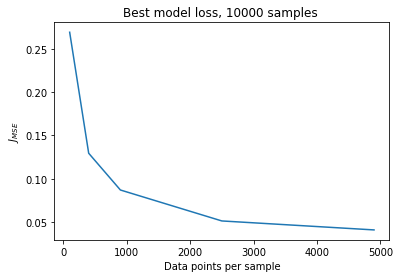

In [15]:
xs = [10,20,30,50,70]
ys = [
    0.26942141892910004,
    0.12947245151996611,
    0.08696433037519455,
    0.051164472541213035,
    0.04078790558874607
] 
x2s = [x**2 for x in xs]
plt.figure(figsize=(6,4))
plt.plot(x2s, ys)
plt.title("Best model loss, 10000 samples ")
plt.xlabel("Data points per sample")
plt.ylabel("$J_{MSE}$")
plt.show()

In [88]:
pickle.dump(gen_m_cache, open("generators.p", "wb"))

In [ ]:
from numpy.random import seed
from sklearn.model_selection import train_test_split

tup = (100,1,5)
key = (tup, (50000,70))

if key in gen_m_cache:
#     gen_m = gen_m_cache[tup]
    (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
else:
    print(key)
    print(gen_m_cache.keys())
    raise Exception("Trying to use generator that does not exist")

factors_master = [tup]
w_list = [200]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

bal=0.5
explore_mode = False

distro_params = []
pfz_list = []

pfzz = None #numpy.array([])
lookup = {}

i=0
explore_mode=True
toomuch, toolittle, goldi = 0,0,0
for (n_factors, min_active, max_active, _) in factors_list:

    model_list=[]
    rasch=True

    questions=None

    qws_list = []
    sws_list = []
    tr_list = []
    params_list = []
    # questions=None
    real_stu_list=[]
    real_que_list=[]
    perseverance_list=[]
    test_datasets=[]

    pred_list = []

    found = False
    tensorflow.random.set_seed(666)
    seed(666)
    mode = "n"
    
    print(gen_m_cache.keys())
    
    for ss in sss:
        for nit in nits:
            tup = n_factors, min_active, max_active
            key = ((tup,(nit,ss)))
#             gen_m = gen_m_cache[key]
            (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
            while i < 1:
                tw = random.uniform(0.5, 3.5)
                a1 = random.uniform(1, 3.5)
        #         a1 = random.uniform(1, 5)

                if mode=="n":
                    a0n = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))
                else:
                    a0r = random.uniform(-1,8.7)

                print("gening data")
                _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=100, n_questions=100)

                print("run created")
                students2 = students_temp

            #     if questions is None:
                questions = qz_temp

        #                         qn_av = numpy.mean(questions, axis=0)
        #                         qn_std = numpy.std(questions, axis=0)

                if explore_mode:
                    plot_items([], questions, None)

                    bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

                    plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
                    plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
                    plt.show()

                obs=numpy.zeros((len(students2), len(questions)))
                pfz = probs.flatten()
                if pfzz is None:
                    pfzz = numpy.array(pfz)
                else:
                    numpy.concatenate((pfzz, pfz))

                if explore_mode:
                #     plt.hist(probs.flatten(), alpha=0.5)
                    plt.title("Histogram of $p_{pass}$")
                    plt.xlabel("$p_{pass}")
                    plt.ylabel("Frequency")
                    plt.legend()
                    plt.show()
                    plt.hist(pfz.flatten(), alpha=0.5)
                    plt.title("pfz")
                    plt.show()          

                hard = (probs >= 0.5)
                agt = 0 #numpy.zeros_like(probs)
                n_agt_runs = 10
                for _ in range(n_agt_runs):
                    this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
                    this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
                    agt += this_agt / n_agt_runs
                print("*** AGT:", agt)                    

                print(tw, a1, a0)
                mn = numpy.mean(probs.flatten())
                if mn > 0.9:
                    toomuch+=1
                if mn < 0.1:
                    toolittle+=1
                if (mn < 0.6) and (mn > 0.4):
                    goldi +=1

        #         distro_params.append((vmn,agt))
                pfz_list.append(pfz)
                i+=1

        if explore_mode:
        #     plt.hist(probs.flatten(), alpha=0.5)
            plt.title("Histogram of $p_{pass}$")
            plt.xlabel("$p_{pass}")
            plt.ylabel("Frequency")
            plt.legend()
            plt.show()
            plt.hist(pfzz.flatten(), alpha=0.5)
            plt.title("pfz")
            plt.show()
        print(numpy.mean(pfzz), numpy.std(pfzz))
        print(toolittle, goldi, toomuch)

In [103]:
from numpy.random import seed
from sklearn.model_selection import train_test_split

tup = (100,1,5)
key = (tup,(10000,70))
if tup in gen_m_cache:
    gen_m = gen_m_cache[tup]
else:
    raise Exception("Trying to use generator that does not exist")

factors_master = [tup]
w_list = [200]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

bal=0.500
explore_mode = False

distro_params = []


balance_lookup = {}


# for (n_factors, min_active, max_active, _) in factors_list:
bal_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for bal in bal_list:
    i=0
    model_list=[]
    rasch=True

    questions=None

    qws_list = []
    sws_list = []
    tr_list = []
    params_list = []
    # questions=None
    real_stu_list=[]
    real_que_list=[]
    perseverance_list=[]
    test_datasets=[]

    pred_list = []

    tensorflow.random.set_seed(666)
    seed(666)
    found = False
    
    probs_list = []
    pfz_list = []
    while i < 100:
        print("BAL target:", bal)
        tw = random.uniform(0.5, 3.5)
#                         a1 = random.uniform(1, 3.5)
        a1 = random.uniform(1, 3.5)
        a0 = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))
#         a0 = random.uniform(-1,1.6)
#         a0 = random.uniform(-1,3.5)
 
        print("gening data")
        _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=100, n_questions=100)

        print("run created")
        students2 = students_temp

    #     if questions is None:
        questions = qz_temp

#                         qn_av = numpy.mean(questions, axis=0)
#                         qn_std = numpy.std(questions, axis=0)

        if explore_mode:
            plot_items([], questions, None)

            bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

            plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
            plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
            plt.show()

        obs=numpy.zeros((len(students2), len(questions)))

        all_pairs = []
        tr_pairs = []
        v_pairs = []
        tt_pairs = []
        perseverance = []
        slist = list(range(len(students2)))
        random.seed(666)
        shuffle(slist)
        for vi in slist:
#                             c=0
            p_cont = None #(n_students * n_questions)//5
            v_size = p_cont
            qlist= list(range(len(questions)))
            shuffle(qlist)
            first = True
            for mi in qlist:
                if first:
                    tt_pairs.append((vi,mi))
                    first = False
                else:
                    tr_pairs.append((vi,mi))

        print("splitting")
        tr_pairs, _ = train_test_split(tr_pairs, test_size=0.5, shuffle=False)
        tr_pairs, v_pairs = train_test_split(tr_pairs, test_size=0.1, shuffle=False)
        print("splut")

#                         print("scanning")
#                         for pa in tr_pairs:
# #                             print(pa)
#                             if pa in tt_pairs:
#                                 print("TR IN TT")
#                                 raise Exception
#                             if pa in v_pairs:
#                                 print("TR IN V")
#                                 raise Exception
#                         print("scun")

        pfz, sz, qz = stitch_n_split(tr_pairs, probs)
        vpfz, vsz, vqz = stitch_n_split(v_pairs, probs)

        print("lens of pfz and vpfz, tt_pairs", len(pfz), len(vpfz), len(tt_pairs))

#                         print(probs)

        hard = (probs >= 0.5)
        agt = 0 #numpy.zeros_like(probs)
        n_agt_runs = 10
        for _ in range(n_agt_runs):
            this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
            this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
            agt += this_agt / n_agt_runs
        print("*** AGT:", agt)                            

        if explore_mode:
            plt.hist(probs.flatten(), alpha=0.5)
            plt.title("Histogram of $p_{pass}$")
            plt.xlabel("$p_{pass}")
            plt.ylabel("Frequency")
            plt.legend()
            plt.show()

            plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
            plt.title("pfz")
            plt.show()


        print(tw, a1, a0)
        mn = numpy.mean(pfz)
        vmn = numpy.mean(vpfz)
        print(mn, vmn)

        distro_params.append((vmn,agt))
        pfz_list.append(pfz)
        probs_list.append(probs.flatten())
        
        i+=1
    balance_lookup[bal] = (probs_list, pfz_list)



BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92446
2.32734785472902 1.4089365651482209 [[-2.3032851]]
0.09517396184062851 0.09494949494949495
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92295
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.12727272727272726 0.1292929292929293
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92401
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.13198653198653199 0.13333333333333333
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9233600000000001
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.11986531986531987 0.12121212121212122
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9286600000000002
0.6321288704918293 2.446

*** AGT: 0.92301
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.12390572390572391 0.14747474747474748
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92621
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.1191919191919192 0.19393939393939394
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92405
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.12121212121212122 0.15151515151515152
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9274399999999999
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.12300785634118967 0.15757575757575756
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92438
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.13265993265993267 0.15555555555555556
BAL target: 0.1
gening data
run created


*** AGT: 0.9252800000000001
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.11829405162738496 0.14545454545454545
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9223599999999998
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.12368125701459035 0.13333333333333333
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92497
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.12615039281705948 0.12323232323232323
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92281
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.12951739618406286 0.1292929292929293
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92518
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.11380471380471381 0.14747474747474748
BAL target: 0.1
gening data
r

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.89192
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.1961840628507295 0.1919191919191919
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8906700000000001
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.19304152637485972 0.18181818181818182
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8902700000000001
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.19349046015712681 0.1898989898989899
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.88815
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.19797979797979798 0.21212121212121213
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.89178
0.6321288704918293 2.4468548839626463 [[-1.4646655]]

splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.89099
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.19977553310886645 0.16363636363636364
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.89161
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.19124579124579125 0.16565656565656567
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8910600000000001
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.18945005611672278 0.16767676767676767
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.88895
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.19797979797979798 0.19393939393939394
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.89235
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.1941638608305275 

*** AGT: 0.8520199999999999
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.28170594837261503 0.3212121212121212
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8507099999999999
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.28327721661054994 0.3090909090909091
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8506500000000001
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.29068462401795736 0.29494949494949496
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.85646
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2915824915824916 0.28484848484848485
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8519300000000001
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2915824915824916 0.28484848484848485
BAL target

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8508800000000001
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2787878787878788 0.2767676767676768
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.85577
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2835016835016835 0.2686868686868687
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.84784
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2843995510662177 0.2787878787878788
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.85013
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.27901234567901234 0.31313131313131315
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8531300000000002
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.85542
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2841750841750842 0.30505050505050507
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8509099999999998
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2801346801346801 0.30707070707070705
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.85699
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2783389450056117 0.2787878787878788
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.84773
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.29876543209876544 0.2868686868686869
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.84755
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2848484848

*** AGT: 0.82108
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.38496071829405165 0.3838383838383838
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.81945
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.38473625140291806 0.35353535353535354
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.82437
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.3627384960718294 0.35555555555555557
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8224199999999999
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.37957351290684627 0.35353535353535354
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.82116
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.3921436588103255 0.36767676767676766
BAL target: 0.4
gening data
run created
sp

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8245500000000001
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.38002244668911334 0.37777777777777777
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.82169
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.37732884399551064 0.3878787878787879
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.82254
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.3658810325476992 0.3878787878787879
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8249400000000001
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.3824915824915825 0.3717171717171717
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.82428
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0

*** AGT: 0.7965200000000001
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.509090909090909 0.4707070707070707
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79634
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.5003367003367003 0.49696969696969695
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79848
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.500561167227834 0.5313131313131313
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79713
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.5120089786756453 0.5292929292929293
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79421
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.4965207631874299 0.47474747474747475
BAL target: 0.5
gening data
run created
splitting

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79872
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.49270482603815935 0.5131313131313131
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80358
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.5028058361391695 0.49292929292929294
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8015099999999998
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.49809203142536473 0.5111111111111111
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80283
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.5012345679012346 0.49292929292929294
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8012099999999999
0.6321288704918293 2.4468548839626463 [[0.87149364]]


gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8023899999999999
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.4922558922558923 0.4404040404040404
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.7987299999999999
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.520314253647587 0.48282828282828283
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79571
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.5077441077441077 0.4909090909090909
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79556
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.5034792368125701 0.503030303030303
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.7965599999999999
0.6321288704918293 2.44685488396264

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80101
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6377104377104377 0.6282828282828283
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80183
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6444444444444445 0.6121212121212121
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80491
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6296296296296297 0.602020202020202
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80488
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6267115600448934 0.6303030303030303
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8025100000000001
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6334455667789001 0.

*** AGT: 0.8
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6294051627384961 0.6484848484848484
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79922
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6307519640852974 0.6202020202020202
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8043299999999999
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6332210998877665 0.6080808080808081
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80486
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6273849607182941 0.6161616161616161
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80067
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6439955106621773 0.6343434343434343
BAL target: 0.6
gening data
run created
splitting
splut
le

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8334599999999999
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7481481481481481 0.7555555555555555
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.83701
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.762962962962963 0.7616161616161616
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.82811
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7481481481481481 0.7252525252525253
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.83312
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7535353535353535 0.7555555555555555
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.83309
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7548821548821549 0.

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8351900000000001
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7652076318742985 0.795959595959596
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8339300000000002
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7384960718294051 0.7373737373737373
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.834
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.743658810325477 0.7616161616161616
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8358200000000001
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7530864197530864 0.7676767676767676
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8321800000000001
0.6321288704918293 2.4468548839626463 [[2.6

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.83456
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7530864197530864 0.7191919191919192
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.86807
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8161616161616162 0.8343434343434344
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.87289
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8325476992143659 0.8181818181818182
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8731399999999999
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8235690235690236 0.8505050505050505
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8719899999999999
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.82940516273

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8702799999999998
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8395061728395061 0.8404040404040404
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.87322
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8377104377104377 0.8404040404040404
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.87551
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8359147025813692 0.8525252525252526
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.87354
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8278338945005612 0.8404040404040404
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8733100000000001
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.813468013468

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.87217
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8395061728395061 0.8525252525252526
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8696600000000001
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.819304152637486 0.8121212121212121
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.87232
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8246913580246914 0.7717171717171717
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8699399999999999
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8190796857463524 0.8424242424242424
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.87247
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8448933782267

*** AGT: 0.90687
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8909090909090909 0.9111111111111111
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9056200000000001
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8817059483726151 0.9090909090909091
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9054600000000002
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8891133557800225 0.9030303030303031
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9084199999999999
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8749719416386083 0.9090909090909091
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.90513
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8868686868686869 0.8464646464646465
BAL target: 0.9
gening data
run 

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9045899999999999
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8953984287317621 0.901010101010101
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9035300000000002
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8886644219977553 0.8767676767676768
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9065800000000002
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8711560044893378 0.8525252525252526
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9014800000000001
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8938271604938272 0.8606060606060606
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.906
0.6321288704918293 2.4468548839626463 [[3.

In [114]:
# plt.hist(numpy.array(probs_list).flatten())
# plt.title("Counts of pass probabilties (Raw params, 100 trials)")
# plt.xlabel("$p_{pass}$")
# plt.ylabel("Count")

bal_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for bal in bal_list:
    (probs_list, pfz_list) = balance_lookup[bal]
    mnz = [numpy.mean(pfz) for pfz in pfz_list]
    print(bal, numpy.mean(mnz))
#     print(mnz)
    
    #print(numpy.mean(pfz_list))
    print (numpy.sqrt(numpy.mean(numpy.power(numpy.subtract(mnz,bal), 2))))


0.1 0.12537373737373733
0.025918850852463184
0.2 0.1930460157126824
0.009185990422118059
0.3 0.28467789001122334
0.01698054570410695
0.4 0.37958922558922564
0.02211424981871497
0.5 0.500909090909091
0.009078596642037699
0.6 0.634327721661055
0.03538789415854601
0.7 0.753463524130191
0.05404321388259128
0.8 0.828830527497194
0.02978473499873512
0.9 0.8833759820426487
0.017699054235002884


(0.5070707070707071, 0.49696969696969695, 0.5313131313131313, 0.4888888888888889, 0.4484848484848485, 0.5696969696969697, 0.494949494949495, 0.5050505050505051, 0.5515151515151515, 0.501010101010101, 0.49696969696969695, 0.47878787878787876, 0.5111111111111111, 0.5414141414141415, 0.5373737373737374, 0.48484848484848486, 0.49292929292929294, 0.5373737373737374, 0.501010101010101, 0.5171717171717172, 0.5393939393939394, 0.47878787878787876, 0.5595959595959596, 0.45656565656565656, 0.4888888888888889, 0.503030303030303, 0.5292929292929293, 0.4888888888888889, 0.5494949494949495, 0.5292929292929293, 0.5050505050505051, 0.4686868686868687, 0.4767676767676768, 0.4727272727272727, 0.503030303030303, 0.49696969696969695, 0.501010101010101, 0.5070707070707071, 0.49696969696969695, 0.4888888888888889, 0.5212121212121212, 0.5515151515151515, 0.5595959595959596, 0.5313131313131313, 0.5191919191919192, 0.4909090909090909, 0.498989898989899, 0.4484848484848485, 0.5050505050505051, 0.488888888888888

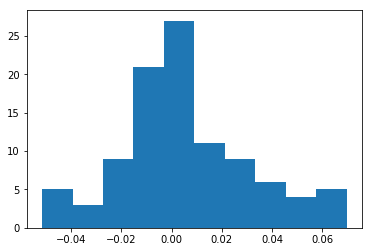

0.025861931601735392


In [89]:
mnz2, agtz2 = zip(*distro_params)
print(mnz2)
mnz2 = numpy.array(mnz2).flatten()
print (numpy.mean(numpy.power(mnz2 - 0.5, 2)))
plt.hist((mnz2 - 0.5))
plt.show()
print (numpy.std((mnz2 - 0.5)))


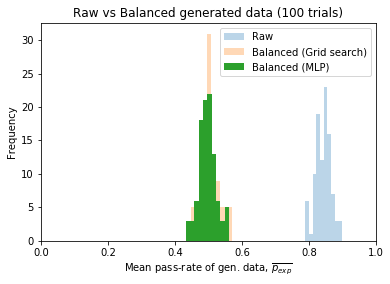

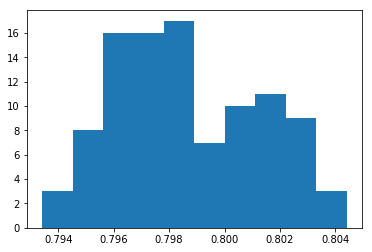

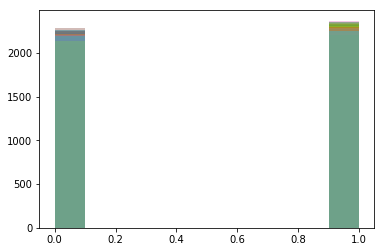

Mean of means: 0.5095465768799102
Std of means: 0.008701296538701837


In [69]:
mnz, agtz = zip(*distro_params)
plt.xlim(0,1)
plt.hist(ub_mnz, label="Raw", alpha=0.3)
plt.hist(hd_mnz, label="Balanced (Grid search)", alpha=0.3)
plt.hist(mnz, label="Balanced (MLP)", alpha=1)
plt.title("Raw vs Balanced generated data (100 trials)")
plt.ylabel("Frequency")
plt.xlabel("Mean pass-rate of generated data, $\overline{p_{exp}}$")
plt.legend()
plt.show()

plt.hist(agtz)
plt.show()

summary_mnz = []
for pfz in pfz_list:
    mn = numpy.mean(pfz)
    summary_mnz.append(mn)
    plt.hist(pfz, alpha=.4)
plt.show()

print("Mean of means:", numpy.mean(summary_mnz))
print("Std of means:", numpy.std(summary_mnz))

In [ ]:
data_cache = {}

In [ ]:
#tw should be ~U[0.5, 3.5]
#sw should be ~N[0, sd] with sd ~U[1, 3.5]
#a0 should be ~U[-0.5, 1]
#missing proportion should be ~U[0, 0.3]

from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split

explore_mode = True

reportz=[]

# factors_master = [(10,1,5)]
factors_master = [(100,1,5)]
w_list = [100]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

# nn_modes = ["MLTM","COND","MXFN"]
nn_modes = ["DEEP"]
loss_modes = ["XENT"]
sq_nums = [(1000, 150)]
# sq_nums = [(3000, 450)]
# student_staminas = [0.01, 0.1, 0.5, 0.75, 1.0]

spars_list = [1.0] # [0.01, 0.05, 0.25, 0.5, 0.75, 1.0]

n_runs = 1
bal = .5

for (n_students, n_questions) in sq_nums:
    for nn_mode in nn_modes:
        for loss_mode in loss_modes:
            for (n_factors, min_active, max_active, emb_w) in factors_list:
                for spars in spars_list:

                    model_list=[]
                    rasch=True

                    questions=None

                    tup = (n_factors, min_active, max_active) 
                    if tup in gen_m_cache:
                        gen_m = gen_m_cache[tup]
                    else:
                        print(gen_m_cache.keys())
                        raise Exception("Genny not found for",tup)
                    
                    qws_list = []
                    sws_list = []
                    tr_list = []
                    params_list = []
                    # questions=None
                    real_stu_list=[]
                    real_que_list=[]
                    perseverance_list=[]
                    test_datasets=[]
                    sparss = []
    #                 qn_av = None
    #                 qn_std = None

                    pred_list = []

                    set_random_seed(666)
                    numpy.random.seed(666)
                    for a in range(n_runs):

                        found = False
                        while not found:
                            tw = random.uniform(0.5, 3.5)
    #                         a1 = random.uniform(1, 3.5)
                            a1 = random.uniform(1, 5)
                            a0 = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))

                            gen_new_data = False
                            if rasch:
                                if tup not in data_cache:
                                    print("Not data in cache for desired shape")
                                    gen_new_data = True
                                else:
                                    print("using datacache")
                                    (probs, students_temp, qz_temp) = data_cache[tup]
                                    if students_temp.shape != (n_students, n_factors) or qz_temp.shape!=(n_questions, n_factors):
                                        print("data shape has changed, need to make new data")
                                        gen_new_data = True
                                
                                if gen_new_data:
                                    print("gening data")
                                    _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
                                

                                
                            print("run created")
                            students2 = students_temp
                            questions = qz_temp

                            if explore_mode:
                                plot_items([], questions, None)

                                print("~ ~ ~ ~~ ATTEMPT",a, a0)
                                bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

                                plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
                                plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
                                plt.show()

                        #     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2), obs2, probs2 = tvt_split(students2, questions, split_mode=1)
                        #     tr_list.append(((sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2)))


    #                         probs=numpy.zeros((len(students2), len(questions)))
                            obs=numpy.zeros((len(students2), len(questions)))

                            all_pairs = []
                            tr_pairs = []
                            v_pairs = []
                            tt_pairs = []
                            perseverance = []
                            slist = list(range(len(students2)))
                            random.seed(666)
                            shuffle(slist)
                            for vi in slist:
    #                             c=0
    #                             p_cont = (n_students * n_questions)//20
    #                             v_size = p_cont
                                qlist= list(range(len(questions)))
                                shuffle(qlist)
                                first = True
                                for mi in qlist:
                                    if first:
                                        tt_pairs.append((vi,mi))
                                        first = False
                                    else:
                                        tr_pairs.append((vi,mi))

                            print("splitting")
                            if spars < 1:
                                tr_pairs, _ = train_test_split(tr_pairs, train_size=spars)
                            tr_pairs, v_pairs = train_test_split(tr_pairs, test_size=0.1)
                            print("splut")

#                             print("scanning")
#                             for pa in tr_pairs:
#     #                             print(pa)
#                                 if pa in tt_pairs:
#                                     print("TR IN TT")
#                                     raise Exception
#                                 if pa in v_pairs:
#                                     print("TR IN V")
#                                     raise Exception
#                             print("scun")

    #                         print("tr_pairs", tr_pairs)
                            pfz, sz, qz = stitch_n_split(tr_pairs, probs)
                            vpfz, vsz, vqz = stitch_n_split(v_pairs, probs)
#                             vpfz, vsz, vqz = [],[],[]

                            print("Sparsity",spars,"lens of pfz and vpfz, tt_pairs", len(pfz), len(vpfz), len(tt_pairs))

                            print(probs)

                            hard =numpy.round(probs)
                            agt = 0 #numpy.zeros_like(probs)
                            n_agt_runs = 10
                            for _ in range(n_agt_runs):
                                this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
                                this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
                                agt += this_agt / n_agt_runs
                            print("*** AGT:", agt)                            

                            if explore_mode:
                                plt.hist(probs.flatten(), alpha=0.5)
                                plt.title("Histogram of $p_{pass}$")
                                plt.xlabel("$p_{pass}")
                                plt.ylabel("Frequency")
                                plt.legend()
                                plt.show()

                                plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
                                plt.title("pfz")
                                plt.show()


                            print(tw, a1, a0)
                            mn = numpy.mean(pfz)
                            print(mn, numpy.mean(vpfz))
                            uppa = bal+0.05
                            lowa = bal-0.05
                            print("xhxwx ELIGIBLE SPREAD for",mn,bal, uppa, lowa)
                            if (mn >= lowa) and (mn <= uppa):
                                print("FOUND ELIGIBLE SPREAD for",mn,bal, uppa, lowa)
                                data_cache[tup] = (probs, students_temp, qz_temp)
                                found=True

                        hard=None
                        probs=None

                        print("mean pers is", numpy.mean(perseverance))
                        perseverance_list.append(perseverance)
                        real_stu_list.append(students2)
                        real_que_list.append(questions)
                        test_datasets.append(tt_pairs)
                        params_list.append((tw,a1,a0,numpy.mean(pfz), numpy.mean(vpfz), agt))
                    #     if numpy.mean(pfz) <0.4 or numpy.mean(pfz)>0.6:
                    #         continue

                    # for runix in range(n_runs):
                    #     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr_list[runix]
                        obs_are_binary = numpy.array_equal(numpy.array(pfz).flatten(), numpy.array(pfz).flatten().astype(bool))
                        print("binary obs?", obs_are_binary)

                        print("callio:")
                        print(len(qz),len(sz),len(pfz))
                        print(len(vqz),len(vsz),len(vpfz), emb_w)
    #                     nn_mode = "MLTM"
    #                     loss_mode = "XENT"
                        print("nn_mode", nn_mode)
                        s_table2, qn_table2, m2, h2 = generate_and_train(n_students, n_questions, qz,sz,pfz, vqz,vsz,vpfz, emb_w, n_factors, min_active, max_active, nn_mode=nn_mode, loss_mode=loss_mode)
    #                     qws2= copy.copy(qn_table2.get_weights()[0])
    #                     sws2= copy.copy(s_table2.get_weights()[0])
                        qws2= qn_table2.get_weights()[0]
                        sws2= s_table2.get_weights()[0]

                        pred_probs = m2.predict([qz, sz])
    #                     print(pred_probs)
                        pred_list.append(pred_probs)
                        model_list.append(m2)

                    #     qg = q_gates.get_weights()[0]
                    #     qg_list.append(qg)
                    #     if qn_av is None:
                    #         qn_av = numpy.mean(qws2)

                        sparss.append(spars)
                        sws_list.append(sws2)
                        qws_list.append(qws2)
                    tup = (n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, sparss)
    #                 reportz.append(zlib.compress(pickle.dumps(tup)))
    #                 print(perseverance_list)

                    reportz.append(tup)
print("finished")

In [ ]:
for tup in reportz:
#     tup = pickle.loads(zlib.decompress(tup_cmp))
    report(*tup)
    
# qws = reportz[0][7][0]
# real_qws = reportz[0][10][0]
# print(qws)
# numpy.set_printoptions(threshold=10000)
# print(real_qws)

# *****
# MLTM XENT
# 1 1 1 1 1 1 1
# params: 10 1 5 1 / 2.5806077740610034 2.347493116108512 [[ 0.821]] 0.459641891892 0.495
# R2 =  0.447788537896
# MAE =  0.204465762654
# 1000 x 150
# 0.749 0.0 / 0.204466 0.144075




In [ ]:
# sws2= s_table2.get_weights()[0]
# qws2= qn_table2.get_weights()[0]

# offset = numpy.mean(students2) - numpy.mean(sws2) 
# qws2 = qws2# + offset
# sws2 = sws2# + offset

bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

for ss in real_stu_list:
    plt.hist(ss.flatten(), alpha=0.2, bins=bin_spread(ss), label="s true")
# plt.legend()
# plt.show()

print("There are {} els in sws_list and {} els in qws_list".format(len(sws_list), len(qws_list)))

sw_av_list = []
for sw in sws_list:
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
    plt.hist(sw.flatten(), alpha=0.2, bins=bin_spread(sw), label="s pred")
    sw_av_list.append(numpy.median(sw.flatten()))
plt.legend()
plt.show()

for qnz in real_que_list:
    plt.hist(qnz.flatten(), alpha=0.2, label="q true", bins=bin_spread(questions))

# qws_list_2 = []
real_max_q = numpy.max(questions.flatten())
print("len qws_list", len(qws_list))

for qw in qws_list:#, sw_av_list):
    qw = copy.copy(qw)
    print("med",numpy.median(qw), "for shape", qw.shape)
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
#     qg2 = (qg>0.5).astype(int)
#     masqd = qw*qg2
#     qws_list_2.append(masqd)
#     print(qw)
#     print(qg)
#     plt.hist(qw[list(set(qz))].flatten(), alpha=0.4, bins=bin_spread(qw)) 

#     max_q = numpy.max(qw)
#     os = real_max_q - max_q
#     qw += os

#     thresh = 0
#     qw[qw < thresh] = 0
    plt.hist(qw.flatten(), alpha=0.2, label="q pred", bins=bin_spread(qw))
plt.legend()
plt.show()


# qws_list = qws_list2

print(len(pred_list))
plt.hist(pfz, alpha=0.2, label="true obs")
plt.hist(probs.flatten(), alpha=0.3, label="true probs")
for ix,predz in enumerate(pred_list):
    plt.hist(predz, alpha=0.1, label=str(ix))
plt.legend()
plt.show()

In [ ]:
plot_items(qws_list[1:], qws_list[0], 0)

In [ ]:
for qw in qws_list:#, sw_av_list):
    print(qw)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
def report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
    
    tot_sqerr = 0
    mean_err_list = []
    mean_std_list = []
    mean_hit_list = []
    
    print("*****")
    print(nn_mode, loss_mode)
#     print("*****")
    print(len(sws_list), len(qws_list), len(model_list), len(real_stu_list), len(real_que_list), len(test_datasets), len(params_list))
    
    for sw,qw,m,stz,qnz,tt_pairs, params, spars in zip(sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
        tw,a1,a0,trbal,vbal,agt = params
        
        print("params:", n_factors, min_active, max_active, emb_w, "/", tw,a1,a0, "(", trbal,vbal,agt,") [",spars,"]")
        
        err_list = []
        true_err_list = []
        hit_list = []
    #     for six,qix in numpy.sort(tt_pairs, axis=0):
    
        true_pz = []
        pred_pz = []
        for six, qix in tt_pairs:
    #         print(six, qix)
    #     print("\n------\n")
    #     continue
    #     if False:
            tq = qnz[qix,:]
            ts = stz[six,:]
            qrow = qw[qix, :]
            srow = sw[six, :]
#             print(qrow)
    #         print("raw",tq,ts)
    #         print("dif",ts-tq)
    #         print(numpy.prod(logistic(ts-tq,1,0)))
            if rasch:
                true_p = float(calc_probs_from_embs(ts.reshape(1,-1),tq.reshape(1,-1)))
#                 dif = ts-tq
#                 true_ps = 1.0 / (1.0 + numpy.exp(-dif))
#                 true_p = numpy.prod(true_ps)
            else:
                true_p = numpy.prod((1-tq)+(ts*tq))
            pred_p = m.predict([[qix],[six]])
            true_pz.append(float(true_p))
            pred_pz.append(float(pred_p))
    #         pred_p = random.random()
    
            mae = numpy.abs(true_p - pred_p)
#             print(true_p, float(pred_p), "err:", float(mae))

            err = true_p - pred_p

            true_err_list.append(err)
            err_list.append(mae)
            good_guess = int(numpy.round(true_p))==int(numpy.round(pred_p))
            hit_list.append(int(good_guess))
    #         sqerr = numpy.power(true_p - pred_p, 2)

#             print(six, qix, ":", srow, qrow)
#             print("-->", pred_p, true_p, " ... ", good_guess)

        print("R2 = ", r2_score(true_pz, pred_pz))
        print("MAE = ", mean_absolute_error(true_pz, pred_pz))
        numpy.set_printoptions(precision=3)
    #     print("Mean sq err {}:".format(qrow.shape), numpy.sqrt(numpy.mean(err_list)))
    
        plt.hist(true_pz, alpha=0.5)
        plt.hist(pred_pz, alpha=0.5)
        plt.show()
        
        plt.hist(numpy.array(true_err_list).flatten(), alpha=0.5)
        plt.show()
        
        mean_err_list.append(numpy.mean(err_list))
        mean_std_list.append(numpy.std(err_list))
        mean_hit_list.append(numpy.mean(hit_list))
    #     print(sum(hit_list), len(hit_list), sum(hit_list)/len(hit_list))

    # print(mean_err_list)
    # print(mean_std_list)
    # print(mean_hit_list)
    # print(params_list)
    print(len(stz),"x",len(qnz))
#     for e,s,acc,params in zip(mean_err_list, mean_std_list, mean_hit_list, params_list):
#         print("acc=",acc)
#         print("mae=",e,"sig=",s)
#         print(params)
#     print("aggregated:")
    print(numpy.median(mean_hit_list), numpy.std(mean_hit_list), "/", numpy.median(mean_err_list), numpy.median(mean_std_list))
    
report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list)

In [ ]:
def mean_ensemble(ref, pred_list):
    summage = numpy.zeros_like(ref)
    for items in pred_list:
        items_aligned, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, ref, items, max_iter=10)        
        print("err", numpy.mean(numpy.abs(items_aligned - ref)))
        summage += items_aligned
    summage /= len(pred_list)
    print("ensem err", numpy.mean(numpy.abs(summage - ref)))
    return summage
#         for item, real_item in zip(items, real_items):
#             print(numpy.sort(real_item))
#             print(numpy.sort(item))
#             print()
            

mean_en = mean_ensemble(qws_list[0], qws_list[1:])
plot_items([], questions, None)
plot_items(qws_list, mean_en, 0)


In [ ]:
print(m_list)
for m,tr in zip(m_list, tr_list):
    (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr
    print(sz2,qz2,pfz2)
    print(vsz2,vqz2,vpfz2)
    print(tsz2,tqz2,tpfz2)
    preds = m.predict(x=[qz2,sz2])
    for sc_true, sc_hat in zip(pfz2,preds):
        print(sc_true, sc_hat)

    # print(m.evaluate(x=[mz,vz], y=scz))
    from sklearn.metrics import mean_absolute_error, mean_absolute_error
    print(mean_absolute_error(numpy.around(pfz2), numpy.around(preds)  ))
    
plt.hist(pfz2)
plt.show()
plt.hist(preds)
plt.show()

In [ ]:
from keras.callbacks import EarlyStopping
min_loss = math.inf
min_v_loss = math.inf
init_patience = 5
for i in range(100):
    print("shiteration i=",i)
    h = m.fit(x=[mz,vz], y=scz, batch_size=1000, epochs=2, shuffle=True, validation_split=1000/len(scz), verbose=1)
    val_loss = h.history["val_loss"][-1]
    loss = h.history["loss"][-1]
    if loss < min_loss and val_loss <= min_v_loss:
        min_v_loss = val_loss
        min_loss = loss
        print("patience reset")
        patience = init_patience
#         sw = s_table.get_weights()
#         qw = qn_table.get_weights()
    else:
        patience -= 1
    if patience==0:
        print("DONE")
        break
#     m.fit(x=[mz,vz], y=numpy.array([(0.5+random.uniform(-0.5,0.5)) for _ in scz]).reshape(-1,1), batch_size=1000, shuffle=False, epochs=10, verbose=0)
    m.fit(x=[mz,vz], y=numpy.array([0.5 for _ in scz]).reshape(-1,1), batch_size=1000, shuffle=False, epochs=2, verbose=0)
    
# s_table.set_weights(sw)
# qn_table.set_weights(qw)

In [ ]:
es = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)
m.fit(x=[mz,vz], y=scz, batch_size=1000, epochs=100, validation_split=1000/len(scz))#, callbacks=[es])

In [ ]:
preds = m.predict(x=[tmz,tvz])
for p, sc_obsv, sc_hat in zip(t_probz, tscz,preds):
    print(p, sc_obsv, sc_hat, (numpy.around(sc_obsv)==numpy.around(sc_hat)))

# print(m.evaluate(x=[tmz,tvz], y=tscz))
from sklearn.metrics import accuracy_score, mean_absolute_error

print("obvsd acc", accuracy_score(numpy.around(tscz), numpy.around(preds)))
print("non-stoch acc", accuracy_score(numpy.around(t_probz), numpy.around(preds)))
print(mean_absolute_error(t_probz, preds))
#0.000302638761699 MSE MxMul


In [ ]:
    plt.hist(obs.flatten())
    plt.show()
    print(numpy.sum(numpy.around(obs)))
    print(len(obs.flatten()))
    

In [ ]:
pred_wgts = qn_table.get_weights()[0]
real_wgts = movies

split = 0

items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_wgts, pred_wgts, max_iter=10)

In [ ]:
print(min_total_err, total_q_err, total_s_err)

print(items_chosen)



In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
# pca = TSNE(n_components=2)

itemz_pred = items_chosen
n = len(items_chosen)
itemz = movies

# s_pred_mean = numpy.mean(s_table.get_weights()[0])
base = min( numpy.min(itemz_pred), numpy.min(itemz))
# ss1 = StandardScaler()
# itemz_pred = ss1.fit_transform(itemz_pred)
# itemz = ss1.transform(movies)

itemz = itemz - base
itemz_pred = itemz_pred - base

print(itemz)
print(itemz_pred)

In [ ]:
# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
# itemz_2 = itemz
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

fig.show()

In [ ]:
numpy.set_printoptions(precision=2, suppress=True, threshold=100)
def create_adj_mx(nodes):
    L = numpy.zeros((len(nodes), len(nodes)))
    for i in range(len(nodes)):
        sum_dist = 0
        for j in range(len(nodes)):
            dist = numpy.linalg.norm(nodes[j]-nodes[i], ord=2)
            L[i,j] = dist
    return L

def create_laplacian(nodes):
    amx = create_adj_mx(nodes)
    L = -amx #negate the adj mx
    for ix,row in enumerate(L):
        deg = -numpy.sum(row)
        L[ix,ix] = deg
    return L

def graph_adj_mx(L, n=3, fn="adj_mx"):
    from graphviz import Graph
    gg = Graph(strict=True, filename=fn)
    if L[0,1]<0:
        L = -L
    for ix in range(len(L)):
        row = L[ix,:]
        js = numpy.argsort(row)[1:n+1]
        for j in js:
            v = row[j]
            tup = str(ix),str(j),str(round(v,2))
#             print("cadd edge", tup)
            sta,end,lab = tup
            gg.edge(sta,end, label=str(lab))
    gg.view()


amx = create_adj_mx(questions)
print(amx)
graph_adj_mx(amx)

    
# numpy.set_printoptions(precision=2, suppress=True, threshold=100000)
# print(L0.argsort(axis=1))
m=3
L1 = create_laplacian(questions)
print(L1)
graph_adj_mx(L1, fn="original", n=m)

for j,q in enumerate(qws_list):
    L1 = create_laplacian(q)
    graph_adj_mx(L1, fn="facsimile_{}".format(j), n=m)

# lams = numpy.linalg.eigvalsh(L0)
# sum_eig = sum(lams)
# sum_upto = 0
# ct=0
# for lam in lams:
#     sum_upto += lam
#     if sum_upto > 0.9*sum_eig:
#         print("broke loop at \lambda_{}".format(ct))
#         break
#     ct+=1